In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from sklearn.model_selection import KFold, LeaveOneOut

import time

np.random.seed(12345)

# Set number of folds

In [2]:
# Comment out if using Leave One Out
K = 12

In [3]:
import numpy as np
import pandas as pd

from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize

import jax
import jax.numpy as jnp
from jax import jit, jacfwd, vmap, random
from jax.experimental.ode import odeint

# import MCMC library
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC

from tqdm import tqdm

### Basic usage ###

'''
# import ODE
from autode.autode import ODE

# instantiate ODE fit
model = ODE(system, df, params)

# fit to data
params = model.fit()

where df has columns [Time, Treatments, S1, ..., SN]
'''

# define function that returns model sensitivity vector
def runODE(t_eval, x, params, ctrl_params, dX_dt):
    # solve ODE model
    y = odeint(dX_dt, x, t_eval, params, ctrl_params)
    return y

# function to compute ODE gradients
def dZdt(system, Z, t, x, params, ctrl_params):

    # compute Jacobian (gradient of model w.r.t. x)
    Jx = jacfwd(system, 1)(t, x, params, ctrl_params)

    # compute gradient of model w.r.t. parameters
    Jp = jacfwd(system, 2)(t, x, params, ctrl_params)

    return Jx@Z + Jp

# define function that returns model sensitivity vector
def runODEZ(t_eval, x, params, ctrl_params, dXZ_dt):
    # check dimensions
    dim_x = len(x)
    n_params = len(params)
    dim_z = dim_x*n_params

    # set initial condition to z equal to zeros
    xz = jnp.concatenate((x, np.zeros(dim_z)))

    # solve ODE model
    y = odeint(dXZ_dt, xz, t_eval, params, ctrl_params)

    return y

### Function to process dataframes ###

def process_df(df, sys_vars, measured_vars, controls):
    # store treatment names
    all_treatments = df.Treatments.values
    unique_treatments = np.unique(all_treatments)

    # store measured datasets for quick access
    data = []
    for i,treatment in enumerate(unique_treatments):

        # pull community trajectory
        comm_inds = np.in1d(df['Treatments'].values, treatment)
        comm_data = df.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)

        # pull evaluation times
        t_eval = np.array(comm_data['Time'].values, float)

        # pull initial condition
        Y_init = np.array(comm_data[sys_vars].values[0], float)
        
        # pull system data
        Y_measured = np.array(comm_data[measured_vars].values, float)

        # pull control params
        ctrl_params = np.array(comm_data[controls].values, float)

        # append t_eval and Y_measured to data list
        data.append([t_eval, Y_init, Y_measured, ctrl_params])
    return data

class ODE:
    def __init__(self, system, dataframes, compressors, params, sys_vars, measured_vars, controls = [],
                 alpha_0=1., prior=None, verbose=True):
        '''
        system: a system of differential equations

        dfs: dataframes each with columns
        [Treatment], [Time], [x_1], ..., [x_n], [control_1], ..., [control_m]

        sys_vars: List of variable names of all model outputs as they appear in
                  dataframe (df). (Includes measured and unobserved outputs)

        params: initial guess of model parameters

        measured_sys_vars: List of observed (measured) model outputs

        control_param

        '''

        # make sure params are 1-dimensional
        self.params = np.array(params).ravel()
        if prior is not None:
            self.prior = np.array(prior).ravel()
        else:
            self.prior = np.zeros_like(params)

        # initial degree of regularization
        self.alpha_0 = alpha_0

        # number of parameters
        self.n_params = len(params)

        # dimension of model output
        self.sys_vars = sys_vars
        self.measured_vars = measured_vars
        self.n_sys_vars = len(sys_vars)

        # control input
        self.controls = controls
        self.n_ctrls = len(controls)

        # set compressors 
        self.compressors = []
        for compressor in compressors:
            # vmap over all time points 
            self.compressors.append(jit(vmap(compressor)))
        
        # store derivative of compressors 
        self.compressor_primes = []
        for compressor in compressors:
            # vmap over all time points 
            self.compressor_primes.append(jit(vmap(jacfwd(compressor))))
            
        # set up data
        self.datasets = []
        for i,(df, measured_var) in enumerate(zip(dataframes, measured_vars)):
            self.datasets.append(process_df(df, sys_vars, measured_var, controls))
            
        # for additional output messages
        self.verbose = verbose

        # set parameters of precision hyper-priors
        self.a = 1e-4
        self.b = 1e-4

        # set prior parameter precision to None
        self.Alpha = None

        # jit compile differential equation
        def dX_dt(x, t, params, ctrl_params):
            # concatentate x and z
            return system(t, x, params, ctrl_params)
        self.dX_dt = jit(dX_dt)

        # if not vectorized, xz will be 1-D
        dim_z = len(sys_vars)*len(params)
        def dXZ_dt(xz, t, params, ctrl_params):
            # split up x and z
            x = xz[:len(sys_vars)]
            Z = jnp.reshape(xz[len(sys_vars):], [len(sys_vars), len(params)])
            dzdt = jnp.reshape(dZdt(system, Z, t, x, params, ctrl_params), dim_z)

            # concatentate x and z
            dXZdt = jnp.concatenate([system(t, x, params, ctrl_params), dzdt])
            return dXZdt
        self.dXZ_dt = jit(dXZ_dt)

        # jit compile function to integrate ODE
        self.runODE  = jit(lambda t_eval, x, params, ctrl_params: runODE(t_eval, x, params, ctrl_params, self.dX_dt))
        self.runODEZ = jit(lambda t_eval, x, params, ctrl_params: runODEZ(t_eval, x, params, ctrl_params, self.dXZ_dt))

        # jit compile matrix operations
        def SSE_next(Y_error, G, Ainv):
            return jnp.sum(Y_error**2) + jnp.einsum('tki,ij,tlj->', G, Ainv, G)
        self.SSE_next = jit(SSE_next)

        def yCOV_next(Y_error, G, Ainv):
            return jnp.einsum('tk,tl->kl', Y_error, Y_error) + jnp.einsum('tki,ij,tlj->kl', G, Ainv, G)
        self.yCOV_next = jit(yCOV_next)

        def A_next(G, Beta):
            return jnp.einsum('tki, kl, tlj->ij', G, Beta, G)
        self.A_next = jit(A_next)

        def GAinvG(G, Ainv):
            return jnp.einsum('tki,ij,tlj->tkl', G, Ainv, G)
        self.GAinvG = jit(GAinvG)

        def NewtonStep(A, g):
            return jnp.linalg.solve(A,g)
        self.NewtonStep = jit(NewtonStep)

        def eval_grad_NLP(Y_error, Beta, G):
            return jnp.einsum('tk,kl,tli->i', Y_error, Beta, G)
        self.eval_grad_NLP = jit(eval_grad_NLP)

    def fit(self, evidence_tol=1e-3, beta_tol=1e-3):
        
        # fit on datasets 
        for i,dataset in enumerate(self.datasets):
            
            # estimate parameters using gradient descent
            convergence = np.inf
            previdence  = -np.inf

            while convergence > evidence_tol:
                # update Alpha and Beta hyper-parameters
                if i == 0:
                    self.update_precision(i)
                # fit using updated Alpha and Beta
                self.res = minimize(fun=self.objective, x0=self.params, args = (i,),
                           jac=True, hess=self.hessian, tol=beta_tol,
                           method='Newton-CG',
                           callback=self.callback)
                if self.verbose:
                    print(self.res)
                self.params = self.res.x
                # update covariance
                self.update_covariance(i)
                # update evidence
                self.update_evidence(i)
                # check convergence
                convergence = np.abs(previdence - self.evidence) / np.max([1.,np.abs(self.evidence)])
                # update evidence
                previdence = np.copy(self.evidence)
                
            # append lower fidelity parameter fitting results
            self.Alpha = np.copy(self.A)
            self.prior = np.copy(self.params)

    # EM algorithm to update hyper-parameters
    def update_precision(self, i):
        print("Updating precision...")

        # loop over each sample in dataset
        SSE = 0.
        yCOV = 0.
        self.N = 0
        for t_eval, Y_init, Y_compressed, ctrl_params in self.datasets[i]:

            # count number of observations
            self.N += len(t_eval[1:]) * np.sum(np.sum(Y_compressed, 0) > 0) / self.n_sys_vars

            # run model using current parameters
            if self.Alpha is None:
                # run ODE on initial condition 
                output = self.runODE(t_eval, Y_init, self.params, ctrl_params)

                # Determine SSE
                Y_error = self.compressors[i](output) - Y_compressed
                SSE  += np.sum(Y_error**2)
                yCOV += np.einsum('tk,tl->kl', Y_error, Y_error)
            else:
                # run model using current parameters, output = [n_time, n_sys_vars]
                output = self.runODEZ(t_eval, Y_init, self.params, ctrl_params)
                Y_predicted = output[:, :self.n_sys_vars]

                # collect gradients and reshape
                G = np.reshape(output[:, self.n_sys_vars:],
                              [output.shape[0], self.n_sys_vars, self.n_params])

                # compress model output and gradient 
                G = np.einsum('tck,tki->tci', self.compressor_primes[i](Y_predicted), G) 
                Y_predicted = self.compressors[i](Y_predicted)

                # Determine SSE
                Y_error = Y_predicted - Y_compressed
                SSE  += self.SSE_next(Y_error, G, self.Ainv)
                yCOV += self.yCOV_next(Y_error, G, self.Ainv)

        ### M step: update hyper-parameters ###
        if self.Alpha is None:
            # target precision
            self.beta = self.N*Y_compressed.shape[-1]/(SSE + 2.*self.b)
            self.Beta = self.N*np.linalg.inv(yCOV + 2.*self.b*np.eye(Y_compressed.shape[-1]))
        else:
            # maximize complete data log-likelihood w.r.t. beta
            self.beta = self.N*Y_compressed.shape[-1]/(SSE + 2.*self.b)
            self.Beta = self.N*np.linalg.inv(yCOV + 2.*self.b*np.eye(Y_compressed.shape[-1]))
            self.Beta = (self.Beta + self.Beta.T)/2.

        ### M step: update hyper-parameters ###
        if self.Alpha is None:
            # initial guess of parameter precision
            self.alpha = self.alpha_0
            self.Alpha = self.alpha_0*np.eye(self.n_params)
        else:
            # maximize complete data log-likelihood w.r.t. alpha and beta
            self.alpha = self.n_params/(np.dot(self.params-self.prior, self.params-self.prior) + np.trace(self.Ainv) + 2.*self.a)
            #self.Alpha = self.alpha*np.ones(self.n_params)
            self.Alpha = np.diag(1./((self.params-self.prior)**2 + np.diag(self.Ainv) + 2.*self.a))

        if self.verbose:
            print("Total samples: {:.0f}, Updated regularization: {:.2e}".format(np.sum(self.N), self.alpha/self.beta))

    def objective(self, params, i):
        # compute residuals
        self.RES = 0.
        # compute negative log posterior (NLP)
        self.NLP = np.einsum('i,ij,j', params-self.prior, self.Alpha, params-self.prior) / 2.
        # compute gradient of negative log posterior
        self.grad_NLP = self.Alpha@(params-self.prior)

        # compute Hessian, covariance of y, sum of squares error
        self.A = np.copy(self.Alpha)

        # loop over each sample in dataset
        for t_eval, Y_init, Y_compressed, ctrl_params in self.datasets[i]:            

            # run model using current parameters, output = [n_time, n_sys_vars]
            output = self.runODEZ(t_eval, Y_init, params, ctrl_params)
            Y_predicted = output[:, :self.n_sys_vars]

            # collect gradients and reshape
            G = np.reshape(output[:, self.n_sys_vars:],
                          [output.shape[0], self.n_sys_vars, self.n_params])

            # compress model output and gradient 
            G = np.einsum('tck,tki->tci', self.compressor_primes[i](Y_predicted), G) 
            Y_predicted = self.compressors[i](Y_predicted)

            # Determine error
            Y_error = Y_predicted - Y_compressed 

            # compute Hessian
            self.A += self.A_next(G, self.Beta)

            # Determine SSE and gradient of SSE
            self.NLP += np.einsum('tk,kl,tl->', Y_error, self.Beta, Y_error)/2.
            self.RES += np.sum(Y_error)/self.N

            # sum over time and outputs to get gradient w.r.t params
            self.grad_NLP += self.eval_grad_NLP(Y_error, self.Beta, G)

        # make sure precision is symmetric
        self.A = (self.A + self.A.T)/2.

        # return NLP and gradient of NLP
        return self.NLP, self.grad_NLP

    def update_covariance(self, i):
        # update parameter covariance matrix given current parameter estimate
        if self.Alpha is None:
            self.A = self.alpha_0*np.eye(self.n_params)
        else:
            self.A = np.copy(self.Alpha)

        # loop over each sample in dataset
        for t_eval, Y_init, Y_compressed, ctrl_params in self.datasets[i]:

            # run model using current parameters, output = [n_time, n_sys_vars]
            output = self.runODEZ(t_eval, Y_init, self.params, ctrl_params)
            Y_predicted = output[:, :self.n_sys_vars]

            # collect gradients and reshape
            G = np.reshape(output[:, self.n_sys_vars:],
                          [output.shape[0], self.n_sys_vars, self.n_params])

            # compress model output and gradient 
            G = np.einsum('tck,tki->tci', self.compressor_primes[i](Y_predicted), G) 

            # compute Hessian
            self.A += self.A_next(G, self.Beta)

        # Laplace approximation of posterior covariance
        self.A = (self.A + self.A.T)/2.
        self.Ainv = np.linalg.inv(self.A)
        self.Ainv = (self.Ainv + self.Ainv.T)/2.

    def update_evidence(self, i):
        # compute evidence
        self.evidence = np.sum(np.log(np.linalg.eigvalsh(self.Alpha)))/2. - \
                        np.sum(np.log(np.linalg.eigvalsh(self.A)))/2. - \
                        self.NLP + self.N*np.sum(np.log(np.linalg.eigvalsh(self.Beta)))/2.
        
        print("Evidence {:.3f}".format(self.evidence))

    def jacobian(self, params, i):
        # compute gradient of cost function
        return self.grad_NLP

    def hessian(self, params, i):
        # compute hessian of NLP
        return self.A

    def callback(self, xk, res=None):
        if self.verbose:
            print("Total weighted fitting error: {:.3f}".format(self.NLP))
        return True

    def predict(self, x_test, teval, ctrl_params=[], compressor=-1):
        # check if precision has been computed
        if self.A is None:
            self.update_covariance()

        # make predictions given initial conditions and evaluation times
        output = self.runODEZ(teval, x_test, self.params, ctrl_params)

        # reshape gradient
        G = np.reshape(output[:, self.n_sys_vars:],
                       [output.shape[0], self.n_sys_vars, self.n_params])

        # compress model output
        Y_predicted = output[:, :self.n_sys_vars]

        # calculate variance of each output (dimension = [steps, outputs])
        covariance = np.linalg.inv(self.Beta) + self.GAinvG(G, self.Ainv)
        get_diag = vmap(jnp.diag, (0,))
        stdv = np.sqrt(get_diag(covariance))

        return Y_predicted, stdv, covariance

# Import data

In [4]:
t0_data = pd.read_csv("DTL0/REU03_table_t0_20220811.csv")
tf_data = pd.read_csv("DTL0/REU03_table_tf_20220811.csv")

exp_info = ['Treatments', 'Rep', 'Time']
inputs = ['Inulin', 'Starch', 'Pectin', 'ArGal', 'Gum', 'AmAc', 'pH']
species = ['BAabs', 'BPabs', 'BTabs', 'BUabs', 'PCabs', 'PJabs',
       'ACabs', 'CGabs', 'CHabs', 'FPabs', 'ERabs', 'BHabs', 'RIabs',
       'CSabs', 'EHabs']

# data with replicates
reps_data = pd.concat((t0_data[exp_info+inputs+species], tf_data[exp_info+inputs+species]))
rep1_data = reps_data.iloc[reps_data['Rep'].values==1].sort_values(by=['Treatments', 'Time'])
rep2_data = reps_data.iloc[reps_data['Rep'].values==2].sort_values(by=['Treatments', 'Time'])

# average replicates
avg_data = rep1_data.copy().drop(['Rep'], axis=1)
avg_data[species] = (avg_data[species].values + rep2_data[species].values)/2.

# normalize data 
t0_inds = avg_data.Time.values == 0.

# normalize values after initial condition 
max_od = 1. # np.max(avg_data[species].iloc[~t0_inds].values, 0)  
species_inds = np.in1d(avg_data.columns.values, species)
# avg_data.iloc[~t0_inds, species_inds] /= max_od

# set initial conditions 
# avg_data.iloc[t0_inds, species_inds] = np.ceil(avg_data.iloc[t0_inds, species_inds].values) / len(species)

avg_data.describe()

,Time,Inulin,Starch,Pectin,ArGal,Gum,AmAc,pH,BAabs,BPabs,...,PJabs,ACabs,CGabs,CHabs,FPabs,ERabs,BHabs,RIabs,CSabs,EHabs
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,...,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,13.185000,0.195693,0.195882,0.216797,0.195792,0.195836,0.510417,0.510417,0.008104,0.030467,...,0.002928,0.003297,0.002506,0.003631,0.000420,0.000478,0.000548,0.000434,0.003535,0.000346
std,13.254213,0.261085,0.261183,0.283816,0.261136,0.261160,0.497251,0.497251,0.018722,0.051681,...,0.004020,0.006745,0.003926,0.005899,0.000267,0.000492,0.000842,0.000249,0.009137,0.000324
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000667,0.000667,...,0.000667,0.000667,0.000667,0.000667,0.000151,0.000169,0.000116,0.000184,0.000552,0.000020
50%,13.185000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.750000,0.000667,0.000667,...,0.000667,0.000667,0.000667,0.000667,0.000622,0.000667,0.000667,0.000606,0.000667,0.000398
75%,26.370000,0.333369,0.334456,0.333762,0.333404,0.333616,1.000000,1.000000,0.004173,0.044809,...,0.003485,0.001384,0.002288,0.004315,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667
max,26.370000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.110081,0.241349,...,0.023777,0.044670,0.015978,0.027096,0.000667,0.004437,0.007572,0.000667,0.050191,0.000667


In [5]:
# import mono-culture data
mono_data = pd.read_csv("DTL0/REU03_table_timeSeriesData_20220811.csv")

# data with replicates
reps_data = mono_data[exp_info+inputs+['OD']].copy()
rep1_data = reps_data.iloc[reps_data['Rep'].values==1].sort_values(by=['Treatments', 'Time'])
rep2_data = reps_data.iloc[reps_data['Rep'].values==2].sort_values(by=['Treatments', 'Time'])

# average replicates
avg_mono_data = rep1_data.copy().drop(['Rep'], axis=1)
avg_mono_data.describe()

,Time,Inulin,Starch,Pectin,ArGal,Gum,AmAc,pH,OD
count,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000
mean,13.350218,0.195693,0.195882,0.216797,0.195792,0.195836,0.510417,0.510417,0.138112
std,8.113401,0.259915,0.260012,0.282544,0.259966,0.259990,0.495023,0.495023,0.124472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001833
25%,6.375556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038898
50%,13.376944,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.750000,0.098247
75%,20.378611,0.333369,0.334456,0.333762,0.333404,0.333616,1.000000,1.000000,0.204613
max,26.379167,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.547167


In [6]:
# insert initial OD 
#avg_mono_data[species] = np.ceil(avg_data.iloc[t0_inds, species_inds].values[0]) / len(species)
avg_mono_data[species] = avg_data.iloc[t0_inds, species_inds].values[0]
avg_mono_data.head()

,Treatments,Time,Inulin,Starch,Pectin,ArGal,Gum,AmAc,pH,OD,...,PJabs,ACabs,CGabs,CHabs,FPabs,ERabs,BHabs,RIabs,CSabs,EHabs
0,REU03_1,0.000000,0.5,0.0,0.0,0.0,0.5,0.0,1.0,0.010000,...,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667
1,REU03_1,2.375000,0.5,0.0,0.0,0.0,0.5,0.0,1.0,0.042733,...,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667
2,REU03_1,4.375278,0.5,0.0,0.0,0.0,0.5,0.0,1.0,0.047980,...,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667
3,REU03_1,6.375556,0.5,0.0,0.0,0.0,0.5,0.0,1.0,0.055872,...,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667
4,REU03_1,8.375833,0.5,0.0,0.0,0.0,0.5,0.0,1.0,0.070998,...,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667


In [7]:
# Define function to make predictions on test data

def test_model(model, df_test, max_od, species, plot=False):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)

    # save true and predicted values
    y_true = []
    y_pred = []
    y_std  = []
    test_treatments = []
    test_times = []
    all_species_names = []

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])
        
        # control parameters 
        ctrl_params = comm_data[inputs].values #[0]

        # test full community
        output, stdv, COV = model.predict(x_test, tspan, ctrl_params=ctrl_params)
        
        # un-normalize
        output_true *= max_od
        output *= max_od
        stdv   *= max_od

        # save predictions after initial value 
        for i, (true, pred, std) in enumerate(zip(output_true[1:], output[1:], stdv[1:])):
            y_true += list(true)
            y_pred += list(pred)
            y_std  += list(std)
            test_times += [tspan[i+1]]*numspecies
            all_species_names += list(species)
            test_treatments += [treatment]*numspecies

        if plot:
            # increase teval
            t_eval = np.linspace(0, tspan[-1]+1)
            steps = len(t_eval)
            output, stdv, COV = model.predict(x_test, t_eval, ctrl_params=ctrl_params)   
            
            # un-normalize
            output *= max_od
            stdv   *= max_od

            # plot the results
            plt.figure(figsize=(9, 6))
            ylim = 0
            for i in range(numspecies):
                out = output[:,i]
                out_true = output_true[:, i]
                std = stdv[:, i]
                if ylim < np.max([np.max(out) + np.max(std)+.1, np.max(out_true)+.1]):
                    ylim = np.max([np.max(out) + np.max(std)+.1, np.max(out_true)+.1])
                if out[0] > 0:
                    plt.scatter(tspan, out_true, color='C{}'.format(i))
                    plt.plot(t_eval, out, label="Predicted species " + str(i+1), color='C{}'.format(i))
                    plt.fill_between(t_eval, out-std, out+std, color='C{}'.format(i), alpha=0.2)

            plt.xlabel("time", fontsize=16)
            plt.ylabel("Abundance", fontsize=16)
            plt.legend(loc='upper left')
            plt.ylim([0, np.min([ylim, 3])])
            plt.title(f"Treatment {treatment} predictions")
            #plt.savefig("Kfold/Figures/{}_{}.pdf".format(dataset.replace("_",""), treatment.replace("<","")))
            #plt.close()
            plt.show()

    return test_treatments, test_times, all_species_names, y_true, y_pred, y_std

In [8]:
# system dimensions
ns = len(species)
nu = len(inputs)
nx = ns + nu

# hidden dimension
nh = 5

# map to hidden dimension
stdv = 1./np.sqrt(nx)
A = np.random.uniform(0, stdv, [nh, nx])

# init bias term
a = np.random.uniform(0, stdv, nh)

# map back to original dimension
stdv = 1./np.sqrt(nh)
B = np.random.uniform(-stdv, 0, [ns, nh])

# init growth rates
b = np.random.uniform(0, stdv, ns)

# init carrying capacities 
t0_inds = avg_data.Time.values == 0.
c = 1./np.max(avg_data[species].values, 0)

# concatenate parameters 
params = np.concatenate((A.flatten(), a, B.flatten(), b, c))
prior  = np.zeros_like(params)
prior[-ns:] = c

n_params = len(params)
n_params

220

In [9]:
# using NODE model 
def system(t, s, params, ctrl_params): 

    # append species to ctrl params
    x = jnp.concatenate((s, ctrl_params[0]))
    
    # map to hidden dimension
    A = jnp.reshape(params[:nh*nx], [nh,nx])
    a = params[nh*nx:nh*nx+nh]

    # map back to original dimension
    B = jnp.reshape(params[nh*nx+nh:nh*nx+nh+nh*ns], [ns,nh])
    b = params[nh*nx+nh+nh*ns:nh*nx+nh+nh*ns+ns]

    # carrying capacity
    c = params[nh*nx+nh+nh*ns+ns:nh*nx+nh+nh*ns+ns+ns]
    
    # compute hidden dimension
    h = jnp.tanh(A@x + a)

    # rate of change of species 
    dsdt = s * (B@h + b) * (1. - c*s)

    return dsdt

In [10]:
# define compression functions 
compressor0 = lambda x: jnp.expand_dims(jnp.sum(x*max_od), 0)     # sum over outputs 
compressor1 = lambda x: x

compressors = [compressor0, compressor1]

## Define ODE (time, x, parameters, u(t), control parameters)

In [11]:
# pull treatment names 
all_mono_treatments = avg_mono_data.Treatments.values
all_treatments = avg_data.Treatments.values
unique_treatments = np.unique(all_treatments)

# set up kfold iterator
kf = KFold(n_splits = K) 

# set up list of measured and predicted values
kfold_species_names = []
kfold_y_true = []
kfold_y_pred = []
kfold_y_stdv = []

# iterate over folds 
#for train_index, test_index in kf.split(unique_treatments):
train_index, test_index = next(iter(kf.split(unique_treatments)))

# get index of train and test data
train_inds_mono = np.in1d(all_mono_treatments, unique_treatments[train_index])
train_inds = np.in1d(all_treatments, unique_treatments[train_index])
test_inds  = np.in1d(all_treatments, unique_treatments[test_index])

# pull out train and test data 
df_train_mono = avg_mono_data.iloc[train_inds_mono].copy()
df_train = avg_data.iloc[train_inds].copy()
df_test  = avg_data.iloc[test_inds].copy()

# instantiate gLV fit 
model = ODE(system = system, 
            dataframes=[df_train_mono, df_train],
            compressors = compressors,
            params = params, 
            prior = prior,
            sys_vars = species,
            measured_vars = [['OD'], species],
            controls = inputs,
            verbose=True)

'''model = ODE(system = system, 
            dataframes=[df_train_mono],
            compressors = [compressor0],
            params = params, 
            prior = prior,
            sys_vars = species,
            measured_vars = [['OD']],
            controls = inputs,
            verbose=True)'''

# fit to data 
t0 = time.time()
model.fit(evidence_tol=1e-3, beta_tol=1e-4)
print("Elapsed time {:.2f}s".format(time.time()-t0))

# predict held-out data
test_treatments, test_times, all_species_names, y_true, y_pred, y_std = test_model(model, df_test, max_od, species, plot=False)
kfold_species_names += all_species_names
kfold_y_true += y_true
kfold_y_pred += y_pred
kfold_y_stdv += y_std

Updating precision...
Total samples: 38, Updated regularization: 5.30e-01
Total weighted fitting error: 10.366
Total weighted fitting error: 6.722
Total weighted fitting error: 5.386
Total weighted fitting error: 4.855
Total weighted fitting error: 4.040
Total weighted fitting error: 2.999
Total weighted fitting error: 2.914
Total weighted fitting error: 2.767
Total weighted fitting error: 2.529
Total weighted fitting error: 2.350
Total weighted fitting error: 2.291
Total weighted fitting error: 2.253
Total weighted fitting error: 2.231
Total weighted fitting error: 2.207
Total weighted fitting error: 2.197
Total weighted fitting error: 2.182
Total weighted fitting error: 2.177
Total weighted fitting error: 2.176
Total weighted fitting error: 2.175
Total weighted fitting error: 2.173
Total weighted fitting error: 2.173
     fun: 2.1734005545656014
     jac: array([ 5.60549553e-04, -4.98017471e-07,  7.93681611e-05, -7.38473318e-07,
       -4.08545020e-08,  1.70720159e-06,  3.29531205e-0

Evidence -7.516
Updating precision...
Total samples: 38, Updated regularization: 2.26e-01
Total weighted fitting error: 4.134
Total weighted fitting error: 4.116
Total weighted fitting error: 4.104
Total weighted fitting error: 4.097
Total weighted fitting error: 4.092
Total weighted fitting error: 4.091
Total weighted fitting error: 4.090
Total weighted fitting error: 4.089
Total weighted fitting error: 4.089
Total weighted fitting error: 4.087
Total weighted fitting error: 4.087
     fun: 4.087112678104707
     jac: array([ 1.57456892e-03,  5.22754272e-06,  1.26782432e-03,  5.22431219e-06,
        5.23356721e-06,  5.25126234e-06,  8.91578733e-04,  5.22466144e-06,
        5.28042438e-06,  2.90974276e-06,  5.09590609e-06,  5.17361332e-06,
        2.89414311e-06,  9.64331324e-04,  2.90112803e-06, -1.94707513e-03,
       -3.37168947e-03,  3.84485722e-03, -2.82830000e-03,  8.75928439e-03,
       -6.26959279e-03, -1.27129555e-02, -1.48854766e-03, -2.08112106e-05,
       -5.70524193e-04, -2

Evidence 2.891
Updating precision...
Total samples: 38, Updated regularization: 1.28e-01
Total weighted fitting error: 6.652
Total weighted fitting error: 6.652
     fun: 6.651704719358335
     jac: array([-1.55001972e-03, -7.92773790e-05, -2.23153969e-03, -7.92833744e-05,
       -7.92765059e-05, -7.93681829e-05,  1.06834341e-04, -7.94532825e-05,
       -7.93241197e-05, -8.34164093e-05, -8.00008420e-05, -7.96927488e-05,
       -8.34306120e-05,  3.09969764e-05, -8.34243256e-05, -7.84608722e-03,
       -6.14120439e-02, -2.46633291e-02, -2.78883576e-02,  1.00810565e-02,
       -3.83597836e-02,  4.61632423e-02,  5.01253176e-03,  3.19320505e-04,
       -3.77225764e-02,  3.19308601e-04,  3.19306477e-04,  3.18635022e-04,
       -7.21952459e-03,  3.18226812e-04,  3.18751030e-04,  3.17124533e-04,
        3.15669138e-04,  3.17040540e-04,  3.17117781e-04, -8.36245157e-03,
        3.17120110e-04,  1.75901026e-01,  7.05012456e-02,  1.08029127e-01,
        1.31940961e-01,  2.08141617e-02,  9.6619933

Evidence 9.251
Updating precision...
Total samples: 38, Updated regularization: 9.12e-02
Total weighted fitting error: 9.175
Total weighted fitting error: 9.169
     fun: 9.169449897492575
     jac: array([-9.19433311e-04,  6.05423702e-06, -2.61980575e-03,  6.03904482e-06,
        6.03875378e-06,  5.54468716e-06,  1.49347493e-03,  5.24549978e-06,
        5.63351205e-06, -1.48561085e-05,  2.94653000e-06,  4.26376937e-06,
       -1.48672843e-05,  1.01714116e-03, -1.48622785e-05,  4.46087420e-02,
       -1.46828026e-01,  2.49226391e-02,  7.06247091e-02,  2.51950137e-02,
       -5.26050329e-02,  5.64421713e-03,  1.03939809e-01,  1.48728897e-03,
       -6.22387929e-03,  1.48721284e-03,  1.48717116e-03,  1.48405437e-03,
        1.21630747e-02,  1.48226996e-03,  1.48453680e-03,  1.42851425e-03,
        1.46982609e-03,  1.47664780e-03,  1.42850913e-03,  1.09131131e-02,
        1.42851099e-03,  5.73435664e-01,  3.16289753e-01,  4.78993893e-01,
        7.07230985e-01,  1.18909493e-01,  1.4280144

Evidence 12.259
Updating precision...
Total samples: 38, Updated regularization: 7.75e-02
Total weighted fitting error: 10.963
Total weighted fitting error: 10.954
     fun: 10.954305484308355
     jac: array([ 2.32517160e-03,  2.13928171e-04, -3.93427070e-03,  2.13881722e-04,
        2.13861116e-04,  2.12138519e-04,  1.98607333e-03,  2.11176695e-04,
        2.12391256e-04,  1.63364748e-04,  2.04158714e-04,  2.08053563e-04,
        1.63356133e-04,  1.88950635e-03,  1.63360091e-04,  1.08472586e-01,
       -1.06991149e-01,  1.07449532e-01,  1.82667375e-01,  3.57044376e-02,
       -7.67455995e-03,  1.91385075e-02,  1.62941784e-01,  2.11422774e-03,
        2.19713114e-02,  2.11417605e-03,  2.11414532e-03,  2.11193087e-03,
        1.84349064e-02,  2.11063074e-03,  2.11228500e-03,  2.04213662e-03,
        2.10052775e-03,  2.10634037e-03,  2.04213243e-03,  2.16677524e-02,
        2.04213383e-03,  6.71647787e-01,  3.98024052e-01,  7.44267344e-01,
        1.11034656e+00,  2.02137917e-01,  2.110

Evidence 13.830
Updating precision...
Total samples: 38, Updated regularization: 7.21e-02
Total weighted fitting error: 12.074
Total weighted fitting error: 12.065
     fun: 12.06506119579217
     jac: array([-2.40269490e-03,  1.94746070e-04, -6.73362240e-03,  1.94684952e-04,
        1.94658642e-04,  1.92283653e-04,  1.86747219e-03,  1.90867926e-04,
        1.92636508e-04,  1.18460623e-04,  1.78786344e-04,  1.85818179e-04,
        1.18453638e-04, -5.08688390e-05,  1.18456897e-04,  4.15917635e-02,
       -6.29145801e-02,  1.55780345e-01,  1.40204728e-01,  3.56674530e-02,
        5.98828197e-02,  2.53315270e-03,  1.95836425e-01,  2.47663166e-03,
        3.85611244e-02,  2.47653946e-03,  2.47648638e-03,  2.47330149e-03,
        2.44585369e-02,  2.47176248e-03,  2.47375085e-03,  2.41355645e-03,
        2.46497430e-03,  2.46799365e-03,  2.41355319e-03,  1.48405945e-02,
        2.41355458e-03,  8.34942102e-01,  4.55111444e-01,  7.83686876e-01,
        1.34801674e+00,  2.74751395e-01,  2.4345

Evidence 14.544
Updating precision...
Total samples: 38, Updated regularization: 7.09e-02
Total weighted fitting error: 12.637
Total weighted fitting error: 12.630
     fun: 12.629588573916681
     jac: array([-5.20438515e-03,  2.45030969e-04, -8.34048912e-03,  2.44970666e-04,
        2.44939816e-04,  2.42560753e-04,  1.96268316e-04,  2.41171685e-04,
        2.42904993e-04,  1.56746013e-04,  2.28708028e-04,  2.36157677e-04,
        1.56740658e-04,  2.89286487e-04,  1.56742986e-04,  9.01778340e-02,
       -1.96349993e-02,  1.88860476e-01,  1.46311224e-01,  1.98209696e-02,
        5.39512485e-02,  5.59672713e-03,  2.01768547e-01,  2.59680371e-03,
        5.07024229e-02,  2.59670080e-03,  2.59664538e-03,  2.59269332e-03,
        8.44970904e-03,  2.59042368e-03,  2.59329006e-03,  2.50848290e-03,
        2.57618842e-03,  2.58339220e-03,  2.50848010e-03,  1.81873776e-02,
        2.50848103e-03,  1.03843820e+00,  2.98901975e-01,  7.91418612e-01,
        1.39711607e+00,  3.40173274e-01,  2.282

Evidence 15.633
Updating precision...
Total samples: 38, Updated regularization: 6.97e-02
Total weighted fitting error: 13.135
Total weighted fitting error: 13.129
     fun: 13.129281834122542
     jac: array([-1.36843994e-02,  1.66500686e-04, -1.02969827e-02,  1.66412792e-04,
        1.66369835e-04,  1.62984943e-04,  2.19197012e-04,  1.61019969e-04,
        1.63473072e-04,  6.49885042e-05,  1.44656398e-04,  1.54162291e-04,
        6.49840804e-05, -1.20521616e-03,  6.49861759e-05,  1.41555518e-01,
       -4.14289683e-02,  2.24010795e-01,  2.89586186e-02, -4.09869850e-03,
        4.50913608e-02, -3.53724658e-02,  2.01527134e-01,  2.58076889e-03,
        5.61828688e-02,  2.58079241e-03,  2.58080103e-03,  2.58168951e-03,
        1.29044428e-02,  2.58217473e-03,  2.58159428e-03,  2.53851945e-03,
        2.58520851e-03,  2.58367276e-03,  2.53851758e-03, -2.40112259e-03,
        2.53851851e-03,  1.01834643e+00,  3.42833757e-01,  7.94733703e-01,
        1.34375536e+00,  4.48600382e-01,  2.116

Evidence 16.276
Updating precision...
Total samples: 38, Updated regularization: 6.97e-02
Total weighted fitting error: 13.414
Total weighted fitting error: 13.403
     fun: 13.402692419921687
     jac: array([-1.61462445e-02,  1.21063087e-04, -7.65143940e-03,  1.21006742e-04,
        1.20979734e-04,  1.18663884e-04,  1.65144820e-03,  1.17169111e-04,
        1.19018834e-04,  1.66476239e-05,  1.01888669e-04,  1.11256493e-04,
        1.66443642e-05,  7.83222727e-04,  1.66457612e-05,  1.64451838e-01,
       -1.05091631e-02,  1.67229503e-01,  9.56797600e-03, -7.76460022e-03,
        4.79472280e-02, -8.65962580e-02,  3.73004824e-01,  4.04852349e-03,
        1.61274299e-01,  4.04840102e-03,  4.04832931e-03,  4.04397305e-03,
        4.03495096e-02,  4.04187990e-03,  4.04455280e-03,  3.97148449e-03,
        4.03356459e-03,  4.03678324e-03,  3.97148263e-03,  5.10918312e-02,
        3.97148356e-03,  1.30482209e+00,  8.33523214e-01,  1.34728777e+00,
        1.91348159e+00,  7.39409328e-01,  3.622

Evidence 17.062
Updating precision...
Total samples: 38, Updated regularization: 6.87e-02
Total weighted fitting error: 13.736
Total weighted fitting error: 13.723
     fun: 13.723081383499853
     jac: array([-2.7085472e-02,  7.7638193e-05, -8.7781865e-03,  7.7524339e-05,
        7.7464618e-05,  7.3092408e-05,  2.2723125e-03,  7.0604612e-05,
        7.3713833e-05, -5.5538141e-05,  4.9450318e-05,  6.1910716e-05,
       -5.5540935e-05,  1.8902095e-03, -5.5539538e-05,  1.6097420e-01,
       -5.9003353e-02,  1.5610549e-01,  2.3329914e-02, -4.1142263e-02,
       -8.1654847e-02, -1.9396406e-01,  4.6315619e-01,  4.7516823e-03,
        2.2348280e-01,  4.7517270e-03,  4.7517512e-03,  4.7532180e-03,
        7.2714604e-02,  4.7537908e-03,  4.7530700e-03,  4.7200448e-03,
        4.7570355e-03,  4.7551543e-03,  4.7200429e-03,  5.1645081e-02,
        4.7200439e-03,  1.5157712e+00,  1.0792980e+00,  1.6202545e+00,
        2.1789935e+00,  9.2643154e-01,  4.4399877e+00,  7.0005121e+00,
        4.616392

Evidence 17.361
Updating precision...
Total samples: 38, Updated regularization: 6.85e-02
Total weighted fitting error: 13.874
Total weighted fitting error: 13.857
     fun: 13.857404078636112
     jac: array([-4.05381247e-02,  1.08826207e-05, -1.09792957e-02,  1.09093962e-05,
        1.09261600e-05,  1.12488633e-05,  4.35721828e-03,  1.08445529e-05,
        1.12849521e-05, -1.24100130e-04, -2.40898225e-06,  7.01611862e-06,
       -1.24101993e-04,  2.48638960e-03, -1.24101061e-04,  9.11704898e-02,
       -8.45193416e-02,  8.74720812e-02,  1.14943326e-01, -6.59059063e-02,
       -2.24245042e-01, -4.04876500e-01,  6.45920336e-01,  6.29423046e-03,
        3.51486146e-01,  6.29397854e-03,  6.29384909e-03,  6.28511887e-03,
        9.44855288e-02,  6.28085900e-03,  6.28628070e-03,  6.15158956e-03,
        6.25758898e-03,  6.26910990e-03,  6.15158863e-03,  1.10981062e-01,
        6.15158863e-03,  1.98341131e+00,  1.50672984e+00,  2.20573092e+00,
        2.65811920e+00,  1.17159462e+00,  6.091

Evidence 17.978
Updating precision...
Total samples: 38, Updated regularization: 6.72e-02
Total weighted fitting error: 14.093
Total weighted fitting error: 14.078
     fun: 14.078025095080902
     jac: array([-6.32857010e-02, -3.85579420e-04, -1.86157208e-02, -3.85697931e-04,
       -3.85764055e-04, -3.89803085e-04, -1.71049498e-04, -3.91739421e-04,
       -3.89283756e-04, -4.84676450e-04, -4.05510888e-04, -3.97564843e-04,
       -4.84677847e-04,  1.66957872e-03, -4.84677381e-04,  3.17302942e-02,
       -1.67249933e-01,  5.33174276e-02, -3.01244497e-01, -6.50729388e-02,
       -2.40604043e-01, -6.40486777e-01,  6.68297946e-01,  6.57710526e-03,
        3.55279058e-01,  6.57743681e-03,  6.57761749e-03,  6.58733351e-03,
        1.13902256e-01,  6.59057032e-03,  6.58630766e-03,  6.46256143e-03,
        6.58954307e-03,  6.59420108e-03,  6.46256143e-03,  8.21270719e-02,
        6.46256143e-03,  2.02041936e+00,  1.63456821e+00,  2.12808919e+00,
        2.84742665e+00,  1.23781145e+00,  6.571

Evidence 18.264
Updating precision...
Total samples: 38, Updated regularization: 6.65e-02
Total weighted fitting error: 14.194
Total weighted fitting error: 14.186
     fun: 14.186328357716645
     jac: array([-5.37743494e-02, -3.37322126e-04, -1.62170380e-02, -3.37085105e-04,
       -3.36955069e-04, -3.29521834e-04,  5.61360316e-03, -3.26498062e-04,
       -3.30394250e-04, -3.70576861e-04, -3.17429658e-04, -3.20186373e-04,
       -3.70578258e-04,  2.81974045e-03, -3.70577793e-04, -3.52135897e-02,
       -9.96124744e-02, -5.58186173e-02, -2.60370374e-02, -2.33708397e-02,
       -3.89320850e-02, -3.89661312e-01,  5.31441569e-01,  5.31485584e-03,
        3.33742172e-01,  5.31351985e-03,  5.31278644e-03,  5.26986131e-03,
        6.20844886e-02,  5.25167957e-03,  5.27501386e-03,  5.04790572e-03,
        5.17129945e-03,  5.20863384e-03,  5.04790479e-03,  6.54862747e-02,
        5.04790479e-03,  1.61553454e+00,  1.16275299e+00,  1.82079625e+00,
        2.20249724e+00,  1.11285162e+00,  4.802

Evidence 18.938
Updating precision...
Total samples: 38, Updated regularization: 6.48e-02
Total weighted fitting error: 14.390
Total weighted fitting error: 14.385
     fun: 14.385130476836764
     jac: array([-6.5603420e-02, -5.8629259e-04, -2.0094212e-02, -5.8646663e-04,
       -5.8655906e-04, -5.9139298e-04, -1.1629425e-03, -5.9297273e-04,
       -5.9088669e-04, -5.9592025e-04, -5.9599767e-04, -5.9533305e-04,
       -5.9592118e-04,  1.6749282e-03, -5.9592072e-04, -2.4372846e-02,
       -1.2997389e-01, -5.7658553e-03, -3.7834954e-01, -8.3227076e-02,
       -2.3205695e-01, -4.3559772e-01,  4.5012933e-01,  4.3252404e-03,
        2.3341647e-01,  4.3282909e-03,  4.3299599e-03,  4.4195941e-03,
        4.3999486e-02,  4.4525014e-03,  4.4096508e-03,  4.4905553e-03,
        4.5400551e-03,  4.5138565e-03,  4.4905543e-03,  2.0583192e-02,
        4.4905534e-03,  1.3415222e+00,  9.3520272e-01,  1.5803717e+00,
        1.9554056e+00,  9.1289389e-01,  4.2579155e+00,  6.6204920e+00,
        4.520325

Evidence 19.015
Updating precision...
Total samples: 38, Updated regularization: 6.40e-02
Total weighted fitting error: 14.440
Total weighted fitting error: 14.434
     fun: 14.433961343278568
     jac: array([-8.89821798e-02, -8.76926701e-04, -2.74340045e-02, -8.76881531e-04,
       -8.76854290e-04, -8.74842284e-04, -6.18734397e-03, -8.73679062e-04,
       -8.75132042e-04, -8.08898010e-04, -8.65756650e-04, -8.70006159e-04,
       -8.08898942e-04, -5.95885934e-03, -8.08898476e-04, -1.09499842e-01,
       -2.20081970e-01, -6.87399805e-02, -4.44761485e-01, -1.34840086e-01,
       -4.89008605e-01, -5.48142135e-01,  6.43606484e-01,  6.50765607e-03,
        3.36697757e-01,  6.50350377e-03,  6.50125090e-03,  6.37649139e-03,
        6.90413862e-02,  6.32901955e-03,  6.39062328e-03,  5.88217890e-03,
        6.18040515e-03,  6.23527123e-03,  5.88217890e-03,  6.80582374e-02,
        5.88217890e-03,  2.05534601e+00,  1.14483678e+00,  2.35726142e+00,
        2.29616499e+00,  1.00192940e+00,  5.236

Evidence 19.343
Updating precision...
Total samples: 38, Updated regularization: 6.24e-02
Total weighted fitting error: 14.665
Total weighted fitting error: 14.652
Total weighted fitting error: 14.556
Total weighted fitting error: 14.441
Total weighted fitting error: 14.436
     fun: 14.436121522039347
     jac: array([-3.48635912e-02, -1.54886628e-04, -2.64458768e-02, -1.54497218e-04,
       -1.54289766e-04, -1.42044039e-04, -5.84193133e-03, -1.37103139e-04,
       -1.43483514e-04, -9.56074800e-05, -1.21289166e-04, -1.26912142e-04,
       -9.56074800e-05, -7.53201172e-03, -9.56074800e-05,  4.56631184e-03,
        8.07933807e-02, -2.35539079e-02, -1.74520671e-01,  3.98658887e-02,
        9.30792745e-03, -3.33459228e-01,  8.32117677e-01,  8.66165664e-03,
        4.86098498e-01,  8.65367893e-03,  8.64935480e-03,  8.39086063e-03,
        1.49166912e-01,  8.28087889e-03,  8.42212420e-03,  7.28983385e-03,
        7.85232335e-03,  8.03025439e-03,  7.28983385e-03,  1.60441399e-01,
        7.2

Evidence 18.467
Updating precision...
Total samples: 38, Updated regularization: 6.06e-02
Total weighted fitting error: 14.519
Total weighted fitting error: 14.518
     fun: 14.517579249344083
     jac: array([-1.99899636e-03, -2.01923540e-05, -2.93568382e-03, -2.16694316e-05,
       -2.24646647e-05, -6.44301763e-05,  7.24070705e-04, -7.88600883e-05,
       -5.99470222e-05, -1.09266490e-04, -1.11903995e-04, -1.03209633e-04,
       -1.09266490e-04,  3.97025328e-03, -1.09266490e-04,  2.83553004e-02,
        5.41114211e-02,  5.81805110e-02, -9.96872783e-02, -1.67207360e-01,
       -1.24740005e-02,  1.88051879e-01, -5.73014617e-01, -1.03094466e-02,
       -4.16128248e-01, -1.02570206e-02, -1.02285855e-02, -8.65251478e-03,
       -1.96667254e-01, -8.06144625e-03, -8.82978644e-03, -4.66835126e-03,
       -6.40882878e-03, -6.94265356e-03, -4.66835499e-03, -1.72507018e-01,
       -4.66835126e-03, -1.31634796e+00, -2.09161949e+00, -1.74985194e+00,
       -8.12498689e-01, -1.32208407e+00, -4.415

Evidence 18.637
Updating precision...
Total samples: 38, Updated regularization: 5.99e-02
Total weighted fitting error: 14.606
Total weighted fitting error: 14.604
     fun: 14.60398069399658
     jac: array([-1.91056468e-02,  3.24732857e-04, -2.23253593e-02,  3.26476409e-04,
        3.27423215e-04,  3.75882024e-04,  1.20334607e-03,  3.91503447e-04,
        3.70880123e-04,  3.56069533e-04,  4.26528743e-04,  4.16052644e-04,
        3.56069533e-04, -1.16903707e-03,  3.56069533e-04,  1.08006060e-01,
        1.81055337e-01,  1.40917331e-01,  2.76057720e-01,  1.12990461e-01,
       -1.08953945e-01, -2.15844095e-01,  5.82189918e-01,  6.80214027e-03,
        3.42003733e-01,  6.78508636e-03,  6.77583041e-03,  6.29151054e-03,
        7.22739398e-02,  6.13318151e-03,  6.34210929e-03,  5.32095740e-03,
        5.79134934e-03,  5.89048350e-03,  5.32095553e-03,  7.45775923e-02,
        5.32095740e-03,  2.44967723e+00,  1.44028640e+00,  1.55830646e+00,
        2.21710396e+00,  3.15683484e-01,  1.9354

Evidence 19.572
Updating precision...
Total samples: 38, Updated regularization: 5.85e-02
Total weighted fitting error: 14.905
Total weighted fitting error: 14.861
Total weighted fitting error: 14.782
Total weighted fitting error: 14.661
Total weighted fitting error: 14.658
     fun: 14.657976977575723
     jac: array([-3.1334810e-02, -3.1896215e-04, -2.6274854e-02, -3.1887938e-04,
       -3.1883188e-04, -3.1646283e-04, -5.2144155e-03, -3.1546154e-04,
       -3.1673408e-04, -2.5216001e-04, -3.0934438e-04, -3.1261321e-04,
       -2.5216001e-04, -4.9129212e-03, -2.5216001e-04,  1.0440409e-02,
       -6.7474484e-02, -6.2684894e-02, -2.2946894e-02, -2.7221031e-02,
        1.0940945e-01, -2.6815370e-01,  8.5527873e-01,  9.3283271e-03,
        5.7015961e-01,  9.3298275e-03,  9.3306471e-03,  9.3543315e-03,
        1.3389105e-01,  9.3548428e-03,  9.3533397e-03,  8.3521651e-03,
        9.3021439e-03,  9.3382942e-03,  8.3521670e-03,  1.3702554e-01,
        8.3521670e-03,  3.1777730e+00,  1.38020

Evidence 19.271
Updating precision...
Total samples: 38, Updated regularization: 5.66e-02
Total weighted fitting error: 14.692
Total weighted fitting error: 14.685
     fun: 14.684921905413173
     jac: array([-3.47284675e-02, -1.16671994e-03, -1.51699428e-02, -1.16663042e-03,
       -1.16656802e-03, -1.16210687e-03, -6.68486208e-03, -1.15954049e-03,
       -1.16276252e-03, -9.57425451e-04, -1.14113232e-03, -1.15142274e-03,
       -9.57425451e-04, -5.18460479e-03, -9.57425451e-04, -2.16817260e-01,
       -4.51434195e-01, -2.93671489e-01, -2.02094674e-01, -2.63783634e-01,
       -5.24200559e-01, -6.32491827e-01, -5.72472453e-01, -7.31254043e-03,
       -1.83981940e-01, -7.30246352e-03, -7.29691377e-03, -6.94194203e-03,
       -1.68891162e-01, -6.77575078e-03, -6.98751118e-03, -3.38968774e-03,
       -5.91835240e-03, -6.33715512e-03, -3.38969147e-03, -1.65000677e-01,
       -3.38968774e-03,  9.96701121e-02, -3.67646456e+00, -1.65913773e+00,
        2.21264172e+00, -1.73238385e+00, -5.069

Evidence 18.674
Updating precision...
Total samples: 38, Updated regularization: 5.43e-02
Total weighted fitting error: 14.812
     fun: 14.811859925146168
     jac: array([-8.78160261e-03, -1.59949763e-04, -9.82453674e-03, -1.60236727e-04,
       -1.60389929e-04, -1.69955776e-04,  2.25136429e-03, -1.74381887e-04,
       -1.68747152e-04, -2.15336564e-04, -1.95918721e-04, -1.85850193e-04,
       -2.15336564e-04,  2.60516349e-03, -2.15336564e-04,  9.81493592e-02,
       -3.02830368e-01,  2.24843979e-01,  1.08726442e-01, -1.86049908e-01,
        9.18297172e-02, -1.81120366e-01, -1.12595499e-01, -3.26599926e-03,
       -4.70365658e-02, -3.26010399e-03, -3.25681106e-03, -3.05334828e-03,
       -2.20532436e-02, -2.96242023e-03, -3.07882880e-03, -1.14830025e-03,
       -2.52564019e-03, -2.73399753e-03, -1.14830025e-03, -1.80224958e-03,
       -1.14829652e-03, -1.66055775e+00,  2.27200747e+00, -5.41020930e-03,
       -1.98171675e+00,  2.60905623e-01,  2.46484280e+00, -1.78419626e+00,
       -1

Evidence 19.641
Updating precision...
Total samples: 38, Updated regularization: 5.29e-02
Total weighted fitting error: 15.104
Total weighted fitting error: 15.089
Total weighted fitting error: 15.088
     fun: 15.087923939952717
     jac: array([ 5.35729248e-03,  1.57987117e-04, -1.70838609e-02,  1.57730421e-04,
        1.57588511e-04,  1.48737337e-04,  4.39589750e-03,  1.44462334e-04,
        1.49890315e-04,  4.35236143e-05,  1.21918274e-04,  1.32912421e-04,
        4.35236143e-05,  4.68656607e-03,  4.35236143e-05,  5.11538982e-02,
        1.10086501e-02,  1.81563139e-01, -1.42633915e-03,  1.22006714e-01,
        2.02510625e-01, -4.03184146e-02, -1.04558036e-01, -3.10923113e-03,
        5.37482500e-02, -3.10431840e-03, -3.10158636e-03, -2.92750960e-03,
       -8.07374194e-02, -2.84644286e-03, -2.94985506e-03, -7.67887512e-04,
       -2.41872761e-03, -2.63174786e-03, -7.67891237e-04, -6.79330379e-02,
       -7.67883786e-04, -4.83537078e-01, -1.55949354e-01, -6.62000626e-02,
       -1.

Evidence 20.044
Updating precision...
Total samples: 38, Updated regularization: 5.24e-02
Total weighted fitting error: 15.059
Total weighted fitting error: 15.049
     fun: 15.04881284542663
     jac: array([-4.35798503e-02, -8.91518313e-04, -3.10868993e-02, -8.91284668e-04,
       -8.91147181e-04, -8.82073538e-04, -1.25305774e-02, -8.77446029e-04,
       -8.83292174e-04, -6.49417285e-04, -8.52635712e-04, -8.64707166e-04,
       -6.49417285e-04, -1.04783289e-02, -6.49417285e-04, -6.20651841e-02,
       -1.92543924e-01, -1.61763310e-01, -1.82301819e-01, -1.77086651e-01,
       -1.38178349e-01, -1.34039983e-01,  1.93146682e+00,  2.55502239e-02,
        1.47730124e+00,  2.55420133e-02,  2.55375281e-02,  2.52276827e-02,
        3.75866503e-01,  2.50691865e-02,  2.52695456e-02,  1.96581800e-02,
        2.41628755e-02,  2.46194471e-02,  1.96581725e-02,  3.64978224e-01,
        1.96581725e-02,  7.24554062e+00,  4.43891191e+00,  6.59830618e+00,
        9.43877029e+00,  2.68166685e+00,  1.9099

Evidence 19.553
Updating precision...
Total samples: 38, Updated regularization: 5.04e-02
Total weighted fitting error: 15.153
     fun: 15.152561877885258
     jac: array([-3.62227373e-02, -1.07107183e-03, -1.57764964e-02, -1.07087439e-03,
       -1.07076950e-03, -1.06346083e-03, -8.15048628e-03, -1.05977140e-03,
       -1.06443593e-03, -8.70930729e-04, -1.03984086e-03, -1.04959728e-03,
       -8.70930729e-04, -5.91277704e-03, -8.70930729e-04, -1.13319159e-02,
       -3.10075551e-01, -2.96971798e-02, -1.82583690e-01, -3.26751024e-01,
       -4.13382262e-01, -3.01443756e-01, -3.01031232e-01, -2.02598795e-03,
       -2.75620818e-02, -2.02637399e-03, -2.02647480e-03, -2.02386780e-03,
       -1.56214789e-01, -2.01675482e-03, -2.02499633e-03, -3.85202206e-04,
       -2.00593867e-03, -1.99814048e-03, -3.85209656e-04, -1.36351883e-01,
       -3.85209656e-04,  3.98145974e-01, -1.17426896e+00, -5.53241432e-01,
        1.58110642e+00,  2.65495151e-01, -2.47972393e+00, -1.29052126e+00,
       -3

Evidence 20.169
Updating precision...
Total samples: 38, Updated regularization: 4.94e-02
Total weighted fitting error: 15.385
Total weighted fitting error: 15.378
Total weighted fitting error: 15.376
Total weighted fitting error: 15.281
Total weighted fitting error: 15.281
     fun: 15.280911592371119
     jac: array([-5.03564999e-03, -3.83627601e-04, -1.40846334e-02, -3.83482664e-04,
       -3.83400009e-04, -3.78233031e-04, -3.07522248e-03, -3.75775038e-04,
       -3.78898461e-04, -3.00968764e-04, -3.62447929e-04, -3.69061017e-04,
       -3.00968764e-04, -2.00289395e-03, -3.00968764e-04, -1.11074448e-02,
        2.21180916e-02, -4.17417884e-02, -1.15657210e-01,  9.34326649e-03,
        8.69156346e-02,  3.72734889e-02,  9.28918421e-02,  1.11729826e-03,
        2.33615488e-01,  1.11600745e-03,  1.11532398e-03,  1.07999146e-03,
       -4.92882021e-02,  1.06738834e-03,  1.08395540e-03,  1.73196045e-03,
        9.96715156e-04,  1.03790464e-03,  1.73195673e-03, -2.82937214e-02,
        1.7

Evidence 20.146
Updating precision...
Total samples: 38, Updated regularization: 4.85e-02
Total weighted fitting error: 15.430
Total weighted fitting error: 15.261
Total weighted fitting error: 15.260
     fun: 15.260163924814133
     jac: array([-2.05184594e-02, -3.18176579e-04, -2.10955944e-02, -3.18046659e-04,
       -3.17973900e-04, -3.13202385e-04, -4.40054480e-03, -3.10807140e-04,
       -3.13836033e-04, -2.40721391e-04, -2.97130202e-04, -3.04041314e-04,
       -2.40721391e-04, -2.97679659e-03, -2.40721391e-04,  1.14576221e-02,
       -9.80568826e-02,  9.20944810e-02,  1.06842101e-01, -1.02491289e-01,
       -4.78333682e-02, -2.24487614e-02,  5.40828466e-01,  6.78349845e-03,
        5.33022583e-01,  6.78504491e-03,  6.78607309e-03,  6.83436822e-03,
        3.47569250e-02,  6.85290340e-03,  6.82905829e-03,  6.69940747e-03,
        6.91297976e-03,  6.89211488e-03,  6.69940002e-03,  4.52007391e-02,
        6.69940002e-03,  2.72409678e+00,  7.83626854e-01,  2.13073659e+00,
        4.

Evidence 20.019
Updating precision...
Total samples: 38, Updated regularization: 4.70e-02
Total weighted fitting error: 15.370
Total weighted fitting error: 15.365
Total weighted fitting error: 15.197
Total weighted fitting error: 15.196
     fun: 15.195528645947768
     jac: array([-1.41293723e-02, -1.48658524e-04, -1.85112245e-02, -1.48615800e-04,
       -1.48585415e-04, -1.46791688e-04, -2.81274784e-03, -1.45826372e-04,
       -1.47042563e-04, -9.85107617e-05, -1.39767537e-04, -1.42946257e-04,
       -9.85107617e-05, -1.55439600e-03, -9.85107617e-05, -1.53839409e-01,
        1.00648701e-01, -2.04015970e-01, -1.10891104e-01,  1.29674911e-01,
        1.24403596e-01, -1.12591095e-01,  7.41965830e-01,  8.59363005e-03,
        5.43754339e-01,  8.59529153e-03,  8.59621447e-03,  8.64197966e-03,
        8.46356750e-02,  8.65764078e-03,  8.63724109e-03,  8.08699522e-03,
        8.71699676e-03,  8.69187899e-03,  8.08698777e-03,  9.15440768e-02,
        8.08698777e-03,  3.06069827e+00,  1.8136

Evidence 19.722
Updating precision...
Total samples: 38, Updated regularization: 4.52e-02
Total weighted fitting error: 15.047
Total weighted fitting error: 15.037
     fun: 15.036640420045465
     jac: array([-9.7991107e-03, -3.2120384e-04, -1.4179498e-02, -3.2095599e-04,
       -3.2080559e-04, -3.1124731e-04, -8.1987763e-03, -3.0625099e-04,
       -3.1253789e-04, -1.0760885e-04, -2.7511735e-04, -2.9108138e-04,
       -1.0760885e-04, -5.3561404e-03, -1.0760885e-04, -7.3305309e-02,
        6.0694724e-02, -1.3827890e-01,  1.0797775e-01, -1.3404109e-01,
        3.5372263e-01,  3.7052092e-01,  2.7870889e+00,  3.8089938e-02,
        2.0020778e+00,  3.8074452e-02,  3.8065702e-02,  3.7505634e-02,
        5.8010393e-01,  3.7225105e-02,  3.7579607e-02,  2.7611593e-02,
        3.5620250e-02,  3.6423139e-02,  2.7611593e-02,  4.6610704e-01,
        2.7611608e-02,  9.8698177e+00,  6.5316057e+00,  9.4881153e+00,
        1.2658385e+01,  3.3718135e+00,  2.8398943e+01,  4.0662697e+01,
        2.797673

Evidence 19.045
Updating precision...
Total samples: 38, Updated regularization: 4.22e-02
Total weighted fitting error: 15.074
     fun: 15.073930793439182
     jac: array([-3.31982598e-02, -9.60424542e-04, -1.03266696e-02, -9.60178790e-04,
       -9.60038858e-04, -9.50678485e-04, -8.77164397e-03, -9.45666456e-04,
       -9.51961381e-04, -7.05673709e-04, -9.12930700e-04, -9.29973437e-04,
       -7.05673709e-04, -4.62967902e-03, -7.05674174e-04, -1.82663560e-01,
       -1.80052996e-01, -2.16415167e-01, -3.38543057e-02, -3.14511478e-01,
       -3.27905953e-01, -4.20615554e-01, -3.52291793e-01, -5.82374912e-03,
       -2.23257259e-01, -5.81147661e-03, -5.80463000e-03, -5.36228763e-03,
       -1.77571535e-01, -5.13825379e-03, -5.42090088e-03, -7.61067669e-04,
       -3.87153937e-03, -4.48891055e-03, -7.61067669e-04, -1.15495518e-01,
       -7.61052768e-04,  1.00237751e+00, -2.23870182e+00, -1.04054856e+00,
        2.21274567e+00, -5.12559295e-01, -1.75145817e+00, -2.39412689e+00,
       -3

Evidence 19.554
Updating precision...
Total samples: 38, Updated regularization: 4.10e-02
Total weighted fitting error: 15.257
Total weighted fitting error: 15.137
Total weighted fitting error: 15.137
     fun: 15.136751525374862
     jac: array([-8.91827326e-03, -3.23203392e-04, -5.51654026e-03, -3.23192449e-04,
       -3.23187443e-04, -3.22962878e-04, -2.67859362e-03, -3.22756823e-04,
       -3.22995940e-04, -2.29916302e-04, -3.16658174e-04, -3.20929918e-04,
       -2.29916302e-04, -7.83063471e-04, -2.29916302e-04,  4.51593399e-02,
       -9.90957022e-04, -1.78806961e-01,  1.98577881e-01, -1.67283624e-01,
        9.88039672e-02,  9.66618955e-02,  3.59538078e-01,  2.40681693e-03,
        2.60117412e-01,  2.40761274e-03,  2.40803696e-03,  2.42837192e-03,
       -1.75133906e-02,  2.44536414e-03,  2.42541730e-03,  3.80350789e-03,
        2.82618450e-03,  2.58086435e-03,  3.80350789e-03,  2.17621699e-02,
        3.80351534e-03,  1.80641365e+00,  7.83165574e-01,  1.49615026e+00,
        1.

Evidence 19.456
Updating precision...
Total samples: 38, Updated regularization: 3.96e-02
Total weighted fitting error: 15.249
Total weighted fitting error: 15.246
     fun: 15.246482971462541
     jac: array([-9.24801081e-03, -1.31177367e-04, -9.67495143e-03, -1.31208915e-04,
       -1.31226727e-04, -1.32260146e-04, -9.89058986e-04, -1.32799381e-04,
       -1.32124987e-04, -1.18127908e-04, -1.35132228e-04, -1.34353410e-04,
       -1.18127908e-04,  3.45962588e-04, -1.18127908e-04, -7.56680965e-02,
       -1.76113546e-02,  5.74123859e-02, -1.79811120e-01,  1.03832096e-01,
       -1.30519211e-01, -1.33979559e-01, -4.64251600e-02, -3.17543186e-03,
       -4.04725447e-02, -3.17600556e-03, -3.17653082e-03, -3.19790235e-03,
       -1.37686118e-01, -3.19387275e-03, -3.19659710e-03, -1.97843590e-04,
       -2.76571466e-03, -3.06438259e-03, -1.97843590e-04, -2.73000505e-02,
       -1.97836140e-04, -7.47758508e-01, -6.31072521e-02,  5.38477302e-03,
        7.84493685e-02,  1.38551906e-01,  4.097

Evidence 19.716
Updating precision...
Total samples: 38, Updated regularization: 3.90e-02
Total weighted fitting error: 15.134
Total weighted fitting error: 15.119
     fun: 15.118999321333016
     jac: array([ 2.62225978e-02, -2.25200783e-05, -8.40419717e-03, -2.28466233e-05,
       -2.30221776e-05, -2.92437617e-05, -6.29498437e-03, -2.87084840e-05,
       -2.90056923e-05,  1.15112285e-04, -1.16885640e-05, -1.99647620e-05,
        1.15112285e-04, -3.80745530e-03,  1.15112285e-04,  1.25944316e-01,
        1.24562740e-01, -8.49092007e-03,  1.03476524e-01, -4.38947380e-02,
        4.96197820e-01,  1.13853335e+00,  4.17391539e+00,  5.50559424e-02,
        2.99296641e+00,  5.50538376e-02,  5.50526120e-02,  5.47809228e-02,
        8.16368580e-01,  5.45148663e-02,  5.48373237e-02,  3.99944037e-02,
        5.23864217e-02,  5.34720086e-02,  3.99944037e-02,  6.14003658e-01,
        3.99943888e-02,  1.38704920e+01,  9.91481590e+00,  1.38162012e+01,
        1.75798664e+01,  4.79148865e+00,  3.883

Evidence 18.987
Updating precision...
Total samples: 38, Updated regularization: 3.60e-02
Total weighted fitting error: 15.137
     fun: 15.137363879168147
     jac: array([-2.38584783e-02, -1.10225170e-03, -1.27746705e-02, -1.10268139e-03,
       -1.10291585e-03, -1.11121289e-03, -1.00534055e-02, -1.11045025e-03,
       -1.11088890e-03, -8.47762451e-04, -1.08614250e-03, -1.09813700e-03,
       -8.47762451e-04, -4.68475511e-03, -8.47762451e-04, -1.19827569e-01,
       -2.40134507e-01, -2.86057115e-01, -1.77679062e-01, -2.52073705e-01,
       -5.37786841e-01, -2.58847684e-01, -3.19448799e-01, -5.83961699e-03,
       -1.99966997e-01, -5.85841434e-03, -5.86814852e-03, -6.21630298e-03,
       -2.67995805e-01, -6.17254246e-03, -6.20484212e-03, -4.71211853e-04,
       -5.13488799e-03, -5.64005133e-03, -4.71211853e-04, -1.37418807e-01,
       -4.71226755e-04,  1.80121851e+00, -3.21290493e+00, -1.25804150e+00,
        3.47714472e+00, -1.53276765e+00, -3.54662132e+00, -2.43714261e+00,
       -3

Evidence 19.356
Updating precision...
Total samples: 38, Updated regularization: 3.50e-02
Total weighted fitting error: 15.269
     fun: 15.269265527719295
     jac: array([-8.72757845e-03, -4.71566338e-04, -1.14711076e-02, -4.71789041e-04,
       -4.71909647e-04, -4.77481284e-04, -1.29999500e-03, -4.78685601e-04,
       -4.77001187e-04, -4.05184925e-04, -4.79404000e-04, -4.78771748e-04,
       -4.05184459e-04,  2.62216665e-04, -4.05184925e-04, -1.36187077e-02,
       -6.39854670e-02, -2.28428841e-02, -9.22529101e-02, -1.52941272e-01,
       -1.02015734e-02, -9.05876458e-02, -1.26978293e-01, -4.91980370e-03,
       -2.83632755e-01, -4.94096288e-03, -4.95221000e-03, -5.41405939e-03,
       -1.44522578e-01, -5.44082187e-03, -5.38534857e-03, -1.05672912e-03,
       -4.87570977e-03, -5.13479579e-03, -1.05672912e-03, -1.97367882e-03,
       -1.05674402e-03, -9.09833848e-01,  1.04765749e+00, -2.62170613e-01,
       -1.04257905e+00, -3.52971464e-01,  3.88470531e+00, -2.62509441e+00,
       -1

Evidence 19.539
Updating precision...
Total samples: 38, Updated regularization: 3.45e-02
Total weighted fitting error: 15.132
Total weighted fitting error: 15.119
     fun: 15.11929577517725
     jac: array([ 2.80360505e-02, -1.30341155e-04, -1.92079367e-03, -1.30176893e-04,
       -1.30061875e-04, -1.11843692e-04, -4.03746869e-03, -1.01630227e-04,
       -1.14893191e-04,  1.43742654e-05, -1.02685532e-04, -9.53415874e-05,
        1.43751968e-05, -2.45729182e-03,  1.43742654e-05,  2.02036917e-01,
        1.38687164e-01, -2.06389248e-01,  3.24798286e-01, -2.59086788e-01,
        4.25566107e-01,  1.16961479e+00,  4.34660769e+00,  5.77072501e-02,
        2.98734188e+00,  5.77033497e-02,  5.77004813e-02,  5.70763908e-02,
        8.12624216e-01,  5.66146001e-02,  5.71939573e-02,  4.16368134e-02,
        5.48504815e-02,  5.55891022e-02,  4.16368134e-02,  5.82505584e-01,
        4.16368432e-02,  1.45550308e+01,  1.09490023e+01,  1.48582964e+01,
        1.82624226e+01,  4.54056931e+00,  4.0164

Evidence 18.728
Updating precision...
Total samples: 38, Updated regularization: 3.16e-02
Total weighted fitting error: 15.097
     fun: 15.096740102262508
     jac: array([-3.32027823e-02, -1.38111704e-03, -1.19026694e-02, -1.38092332e-03,
       -1.38079119e-03, -1.35539041e-03, -9.36948415e-03, -1.34022965e-03,
       -1.35979243e-03, -1.06766832e-03, -1.33628433e-03, -1.32821093e-03,
       -1.06766738e-03, -4.26294794e-03, -1.06766832e-03, -8.76619816e-02,
       -2.65477985e-01, -5.37474036e-01, -2.12407112e-03, -4.78824019e-01,
       -6.58964694e-01, -4.26272511e-01, -3.40741873e-01, -8.48800130e-03,
       -3.70203257e-01, -8.47204588e-03, -8.46293475e-03, -7.26926466e-03,
       -3.07413399e-01, -6.64171996e-03, -7.45610800e-03, -6.73093367e-04,
       -5.99816442e-03, -6.03027642e-03, -6.73085917e-04, -1.72134936e-01,
       -6.73063565e-04,  2.06219101e+00, -2.90011311e+00, -9.23992872e-01,
        3.69023108e+00, -2.23586559e+00, -3.98741150e+00, -2.88220215e+00,
       -3

Evidence 19.057
Updating precision...
Total samples: 38, Updated regularization: 3.07e-02
Total weighted fitting error: 15.191
Total weighted fitting error: 15.189
     fun: 15.188934597397003
     jac: array([ 6.8441206e-03, -4.4140767e-04, -2.3809706e-03, -4.4133351e-04,
       -4.4126983e-04, -4.3240667e-04, -5.7550147e-05, -4.2763597e-04,
       -4.3389224e-04, -3.7304545e-04, -4.3802732e-04, -4.2841234e-04,
       -3.7304452e-04,  8.1022596e-04, -3.7304545e-04,  1.7473465e-01,
        2.3292422e-02, -3.1457913e-01,  1.4298344e-01, -2.1618079e-01,
       -4.7982447e-02,  2.2523391e-01,  1.9468965e-01, -5.9544449e-03,
       -8.2121424e-02, -5.9419801e-03, -5.9347763e-03, -4.9586724e-03,
       -1.7814486e-01, -4.4501852e-03, -5.1121423e-03, -2.5018130e-04,
       -4.1766255e-03, -4.0510660e-03, -2.5018130e-04, -4.2421773e-02,
       -2.5015150e-04,  3.4285551e-01,  6.0799479e-02,  5.1736641e-01,
       -1.4760216e+00, -8.4740710e-01, -2.4275243e-01,  8.2067156e-01,
        1.955048

Evidence 19.252
Updating precision...
Total samples: 38, Updated regularization: 3.02e-02
Total weighted fitting error: 15.275
Total weighted fitting error: 15.272
     fun: 15.271606316172466
     jac: array([ 1.13469735e-02, -5.30619873e-04, -6.37020590e-03, -5.30616613e-04,
       -5.30605321e-04, -5.25093172e-04, -2.29390897e-03, -5.21777431e-04,
       -5.26135904e-04, -4.40237345e-04, -5.35597559e-04, -5.24680712e-04,
       -4.40236880e-04,  4.98648733e-05, -4.40237345e-04, -2.26709843e-01,
        1.32005125e-01,  1.42980516e-01, -5.28369367e-01,  1.25783533e-01,
       -3.35024744e-02, -3.76277387e-01,  4.71741110e-02, -8.21455196e-03,
        4.21002973e-03, -8.20875727e-03, -8.20550229e-03, -7.60412961e-03,
       -2.37115726e-01, -7.25705968e-03, -7.70621747e-03, -2.31996831e-03,
       -7.23082386e-03, -7.04276748e-03, -2.31996831e-03, -2.51150411e-02,
       -2.31993850e-03, -1.46473014e+00,  3.87011766e-02,  5.87726355e-01,
       -3.21023893e+00, -2.46179014e-01, -1.266

Evidence 19.371
Updating precision...
Total samples: 38, Updated regularization: 3.00e-02
Total weighted fitting error: 15.304
Total weighted fitting error: 15.303
     fun: 15.303349587871974
     jac: array([ 4.46633883e-02,  4.57914080e-04,  1.39210578e-02,  4.57901042e-04,
        4.57904884e-04,  4.55338741e-04,  2.68256385e-03,  4.53309389e-04,
        4.55839792e-04,  3.71105154e-04,  4.48206905e-04,  4.48845793e-04,
        3.71105154e-04,  6.96545932e-04,  3.71105154e-04,  4.50247526e-02,
        3.85526955e-01, -1.39351666e-01,  1.50673032e-01,  1.84122473e-02,
        3.62163365e-01,  4.54122990e-01,  6.87166214e-01,  1.04149152e-02,
        7.85080075e-01,  1.04088858e-02,  1.04050031e-02,  9.76464525e-03,
        5.55275418e-02,  9.36454441e-03,  9.87436995e-03,  7.82600325e-03,
        8.06186348e-03,  8.59261304e-03,  7.82600325e-03,  1.44114316e-01,
        7.82602932e-03,  1.93779159e+00,  3.10694361e+00,  2.06583071e+00,
        3.74216723e+00,  1.50358784e+00,  8.235

Evidence 19.470
Updating precision...
Total samples: 38, Updated regularization: 2.97e-02
Total weighted fitting error: 15.339
Total weighted fitting error: 15.337
     fun: 15.336850913493041
     jac: array([ 1.23377610e-03, -3.20953084e-04, -4.16246941e-04, -3.21098836e-04,
       -3.21181142e-04, -3.32593801e-04, -3.51747684e-03, -3.39443563e-04,
       -3.30728362e-04, -2.93175806e-04, -3.63044092e-04, -3.53266252e-04,
       -2.93174875e-04, -1.34416576e-03, -2.93175806e-04, -4.53419685e-02,
       -4.42940325e-01,  3.58467817e-01, -2.45125532e-01,  8.63329172e-02,
       -1.02419056e-01, -5.07898986e-01, -1.98267132e-01, -2.90774927e-03,
       -2.06790254e-01, -2.91230762e-03, -2.91539775e-03, -3.53359384e-03,
       -2.40267903e-01, -3.93189210e-03, -3.42457299e-03, -1.24178512e-03,
       -5.16264234e-03, -4.67091799e-03, -1.24178512e-03,  1.87940896e-03,
       -1.24176277e-03, -7.84801364e-01, -5.56134462e-01,  3.82510424e-01,
       -1.72892523e+00, -5.12879789e-01, -1.596

Evidence 19.557
Updating precision...
Total samples: 38, Updated regularization: 2.96e-02
Total weighted fitting error: 15.403
     fun: 15.403002589248533
     jac: array([ 2.71181371e-02,  1.42478384e-04,  4.37611248e-03,  1.42435660e-04,
        1.42423669e-04,  1.37791387e-04,  1.06807798e-04,  1.34540955e-04,
        1.38637726e-04,  1.02930586e-04,  1.25023187e-04,  1.27778738e-04,
        1.02931517e-04,  3.11951153e-05,  1.02930586e-04,  1.19145513e-01,
       -2.22767234e-01,  1.94271505e-01, -9.15730000e-03,  1.51996657e-01,
        1.52522922e-02, -5.07198274e-04,  1.55203074e-01,  6.87013497e-04,
       -5.91517463e-02,  6.84018480e-04,  6.81792852e-04,  1.62042212e-04,
       -1.72341734e-01, -1.85151235e-04,  2.56263651e-04,  1.46092032e-03,
       -1.24412391e-03, -8.32479098e-04,  1.46092032e-03,  4.94579449e-02,
        1.46094267e-03,  1.53336227e-02,  1.07490170e+00, -1.45142674e-01,
        9.88082647e-01,  6.07256830e-01, -1.07886672e-01,  4.48778868e-01,
        1

Evidence 19.527
Updating precision...
Total samples: 38, Updated regularization: 2.96e-02
Total weighted fitting error: 15.439
     fun: 15.439396396167696
     jac: array([ 3.04955803e-02, -1.09307002e-05,  6.27821265e-03, -1.10134715e-05,
       -1.10627152e-05, -1.85341341e-05, -1.05492026e-03, -2.33298633e-05,
       -1.72633445e-05, -2.70699384e-05, -3.95886600e-05, -3.33697535e-05,
       -2.70690070e-05, -3.35445162e-04, -2.70699384e-05,  1.12234175e-01,
       -1.92135438e-01,  9.24394727e-02, -1.19145095e-01,  4.43484932e-02,
        6.77016377e-02,  7.47827813e-02,  1.02184862e-01, -2.62025930e-03,
       -5.79004921e-02, -2.62404094e-03, -2.62671849e-03, -3.19891190e-03,
       -2.14211211e-01, -3.57430032e-03, -3.09667364e-03, -1.13137253e-03,
       -4.74114344e-03, -4.27574944e-03, -1.13137253e-03,  4.73534390e-02,
       -1.13135017e-03, -2.22896099e-01, -5.05030513e-01,  3.27858329e-01,
       -2.23911285e+00, -3.85502130e-02, -4.10812140e-01, -6.24980927e-01,
        1

Evidence 19.661
Updating precision...
Total samples: 38, Updated regularization: 2.95e-02
Total weighted fitting error: 15.496
     fun: 15.49605697020349
     jac: array([ 3.61175723e-02,  2.44531548e-04,  4.64829849e-03,  2.44522467e-04,
        2.44517112e-04,  2.41475413e-04,  8.40926543e-04,  2.39069923e-04,
        2.42074835e-04,  1.90492719e-04,  2.32866500e-04,  2.33958475e-04,
        1.90493185e-04,  3.08949500e-04,  1.90492719e-04,  8.87532234e-02,
       -1.35992393e-01,  3.76462936e-02,  1.06417179e-01,  9.74498540e-02,
        5.37391156e-02,  1.30283773e-01,  2.66295940e-01,  3.75614385e-04,
       -6.74213693e-02,  3.72908660e-04,  3.70888272e-04, -1.38391391e-04,
       -1.77044705e-01, -4.80608433e-04, -4.55656555e-05,  1.31753320e-03,
       -1.52363523e-03, -1.11867359e-03,  1.31753320e-03,  7.25800097e-02,
        1.31755555e-03, -8.62311721e-02,  2.21334815e-01, -3.85329843e-01,
        1.53772330e+00,  6.07091188e-01, -1.87193453e-01,  8.90402794e-02,
        2.

Evidence 19.666
Total weighted fitting error: 1.391
     fun: 1.3906749486207892
     jac: array([-1.99156880e-01, -7.90414517e-04, -4.70335633e-02, -7.90085003e-04,
       -7.89901707e-04, -7.70195504e-04,  8.76723602e-03, -7.59575691e-04,
       -7.73197913e-04, -8.84516630e-04, -7.18681433e-04, -7.38609815e-04,
       -8.84516630e-04,  2.64699920e-03, -8.84516630e-04, -3.35170925e-01,
       -7.22143054e-01, -6.95097864e-01,  7.51272291e-02,  3.51176262e-01,
       -1.51431656e+00, -3.77969670e+00, -7.44375277e+00, -8.96171927e-02,
       -5.43598795e+00, -8.96372646e-02, -8.96490887e-02, -9.10915807e-02,
       -1.98232436e+00, -9.17957276e-02, -9.08737406e-02, -6.15534931e-02,
       -9.25915241e-02, -9.25005376e-02, -6.15534931e-02, -1.25930631e+00,
       -6.15534931e-02, -1.25820055e+01, -2.28622284e+01, -2.61343422e+01,
       -2.08524246e+01, -9.85302639e+00, -4.94570007e+01, -8.83762512e+01,
       -7.46217346e+00, -8.98385048e-02, -5.44957209e+00, -8.98586139e-02,
       -8

Evidence 56.037
Total weighted fitting error: 1.363
     fun: 1.3630827205349316
     jac: array([-7.0096135e-02,  1.2910471e-03, -2.7962953e-02,  1.2915883e-03,
        1.2918997e-03,  1.3247810e-03,  2.0890540e-02,  1.3423025e-03,
        1.3197851e-03,  9.6288312e-04,  1.4070942e-03,  1.3755985e-03,
        9.6288312e-04,  6.5526529e-03,  9.6288312e-04,  1.3134456e-01,
       -5.4366574e-02,  3.9649278e-02,  6.4535320e-01,  6.8184710e-01,
        2.2919229e-01, -8.9578646e-01, -3.8875622e-01, -4.0407148e-03,
       -5.8464658e-01, -4.0458911e-03, -4.0489272e-03, -4.3795812e-03,
       -2.1565996e-01, -4.5504058e-03, -4.3295142e-03, -8.9142192e-04,
       -5.0239596e-03, -4.8235012e-03, -8.9142192e-04, -1.4055213e-01,
       -8.9142192e-04,  3.1179326e+00, -2.0055363e+00, -2.7327034e+00,
       -1.6505014e+00,  2.0738454e+00,  1.2453886e+01,  1.9045812e+00,
       -3.8959432e-01, -4.0493053e-03, -5.8606356e-01, -4.0545161e-03,
       -4.0575438e-03, -4.3890430e-03, -2.1617129e-01, -4

Evidence 56.072
Elapsed time 165.66s


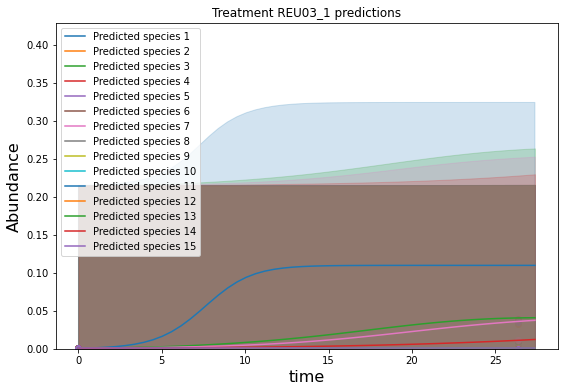

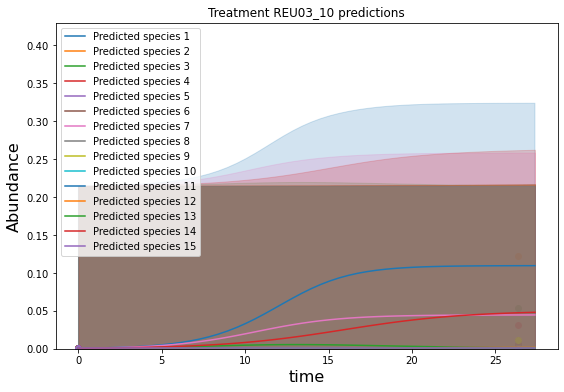

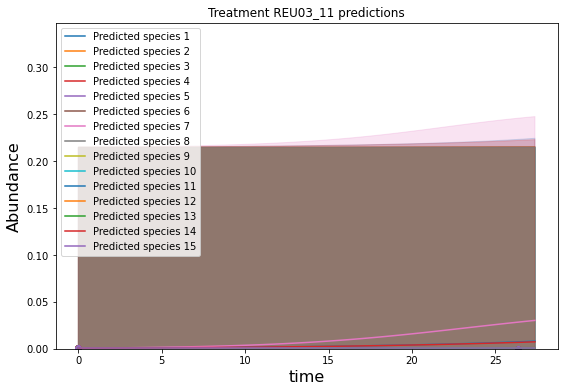

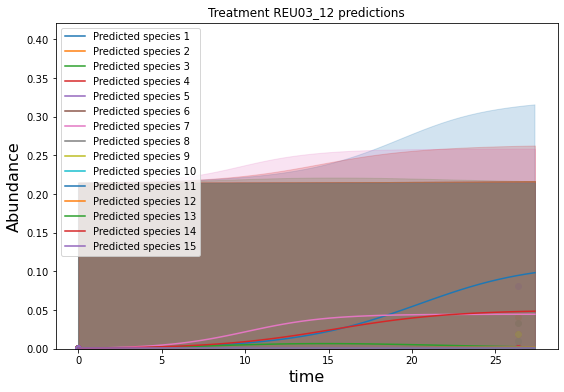

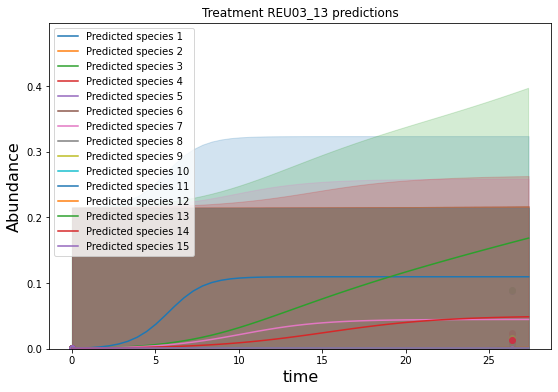

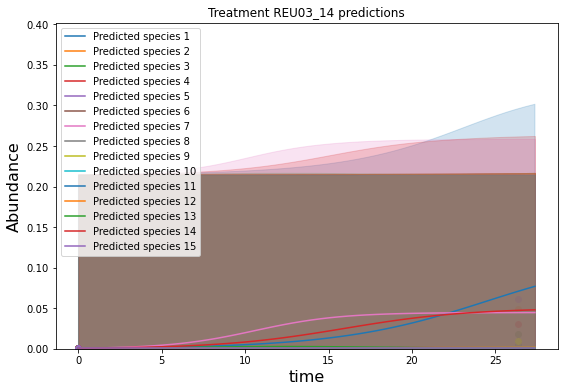

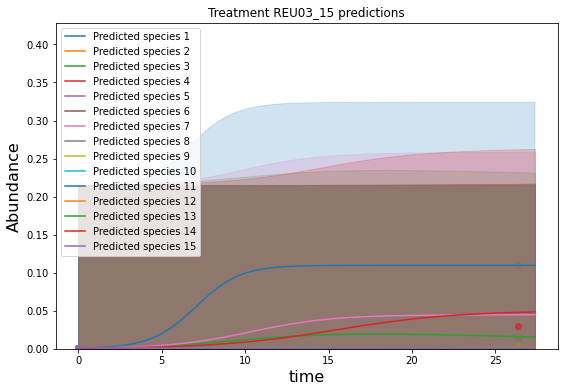

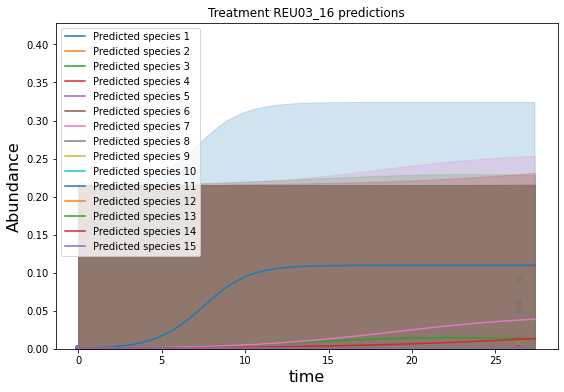

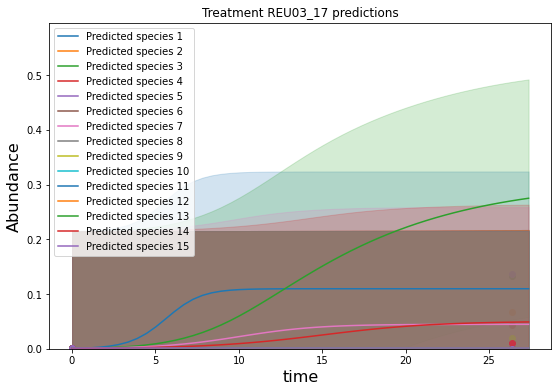

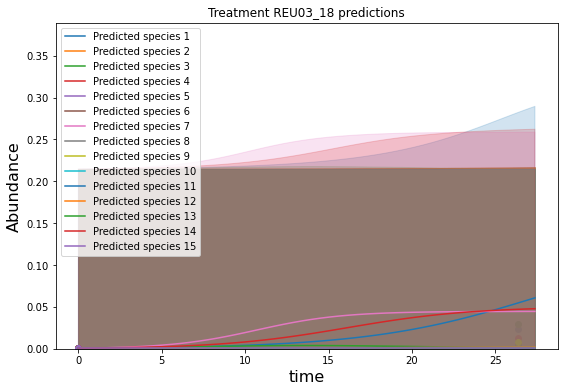

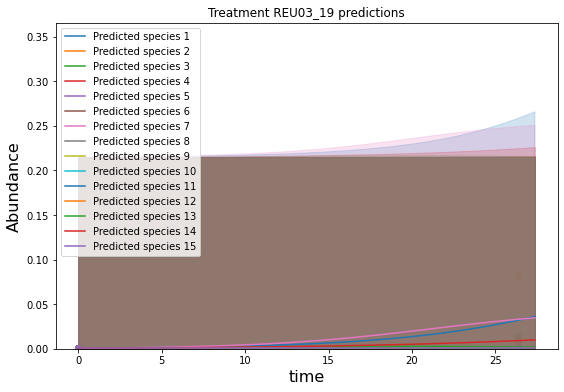

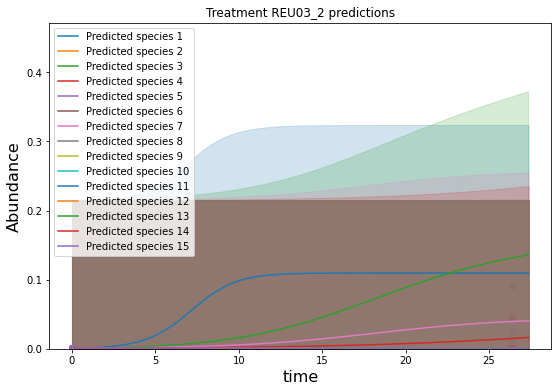

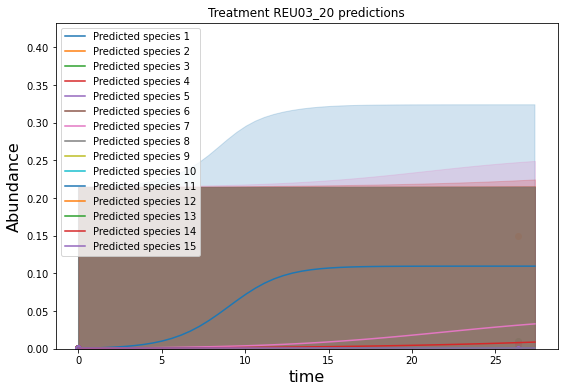

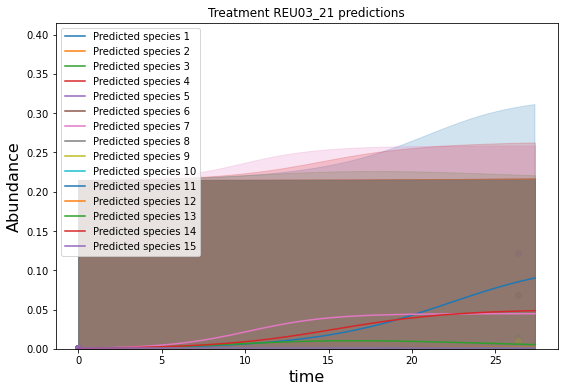

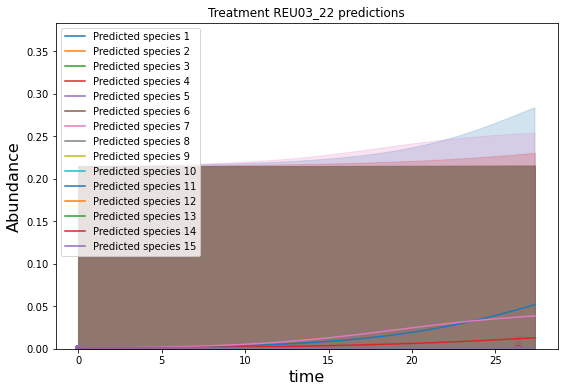

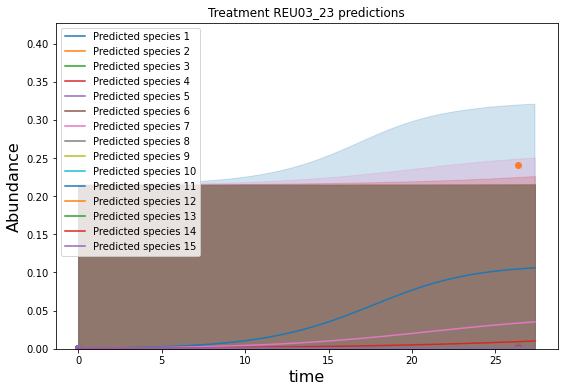

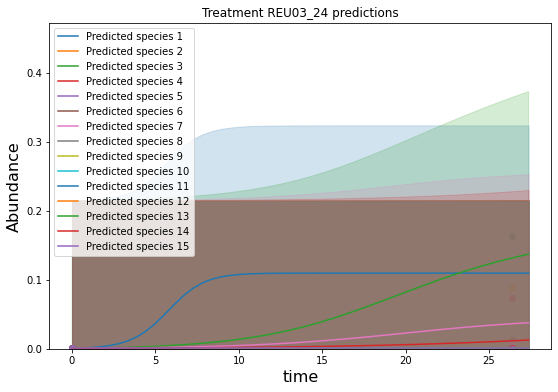

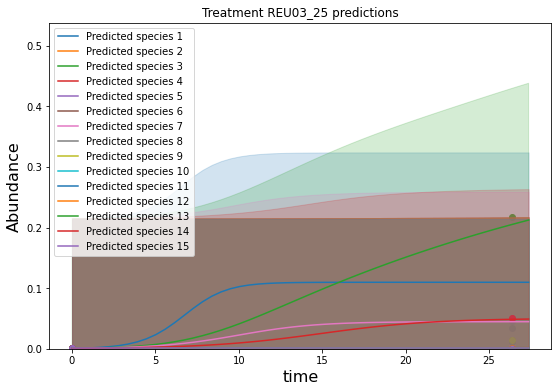

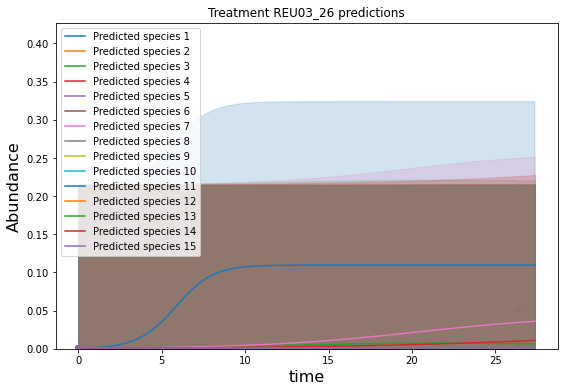

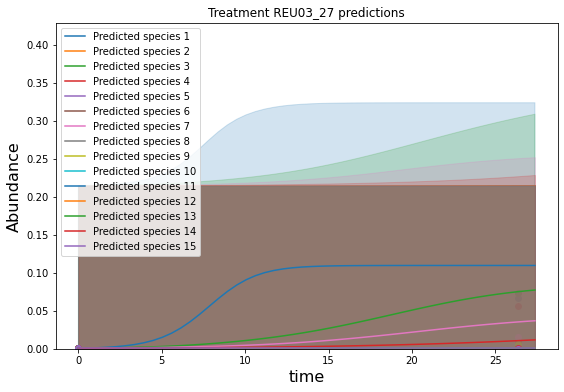

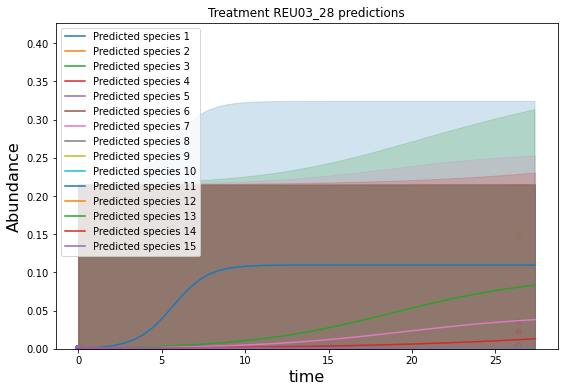

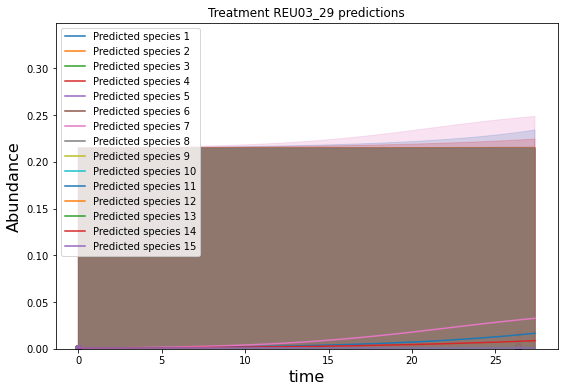

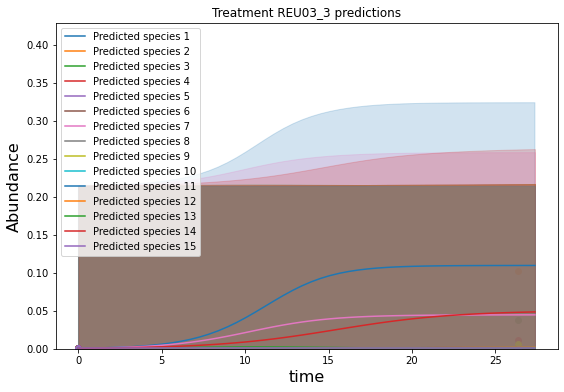

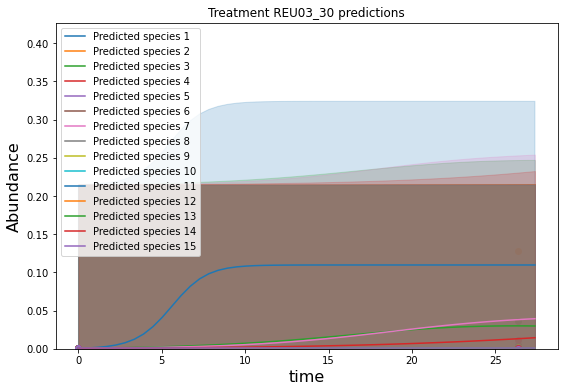

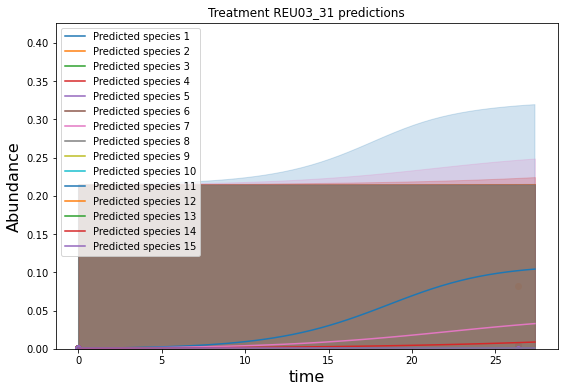

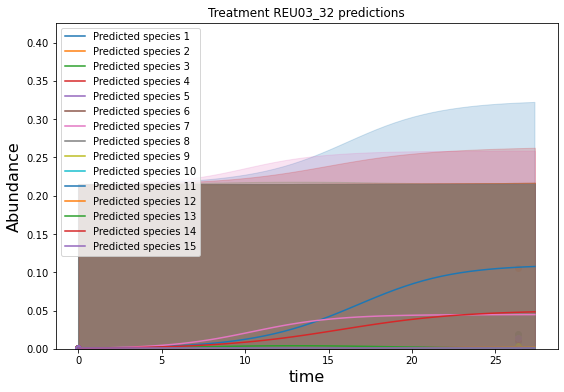

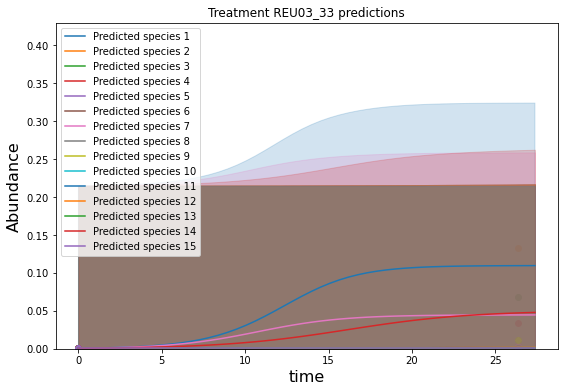

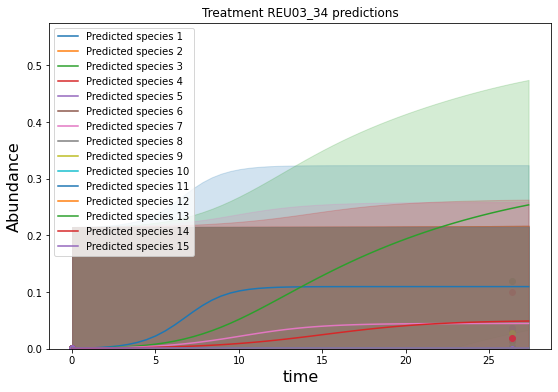

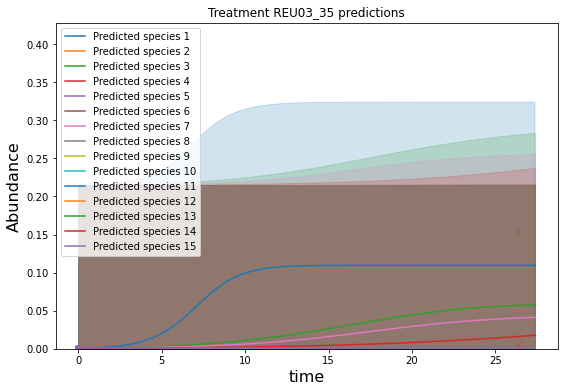

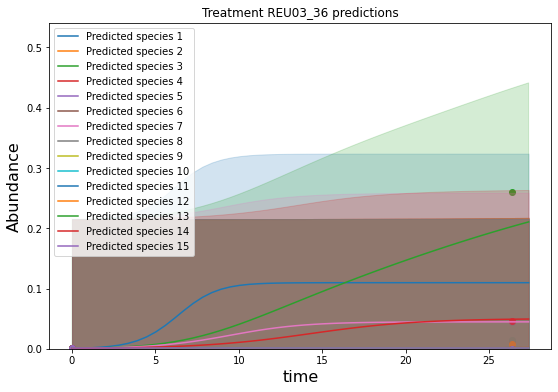

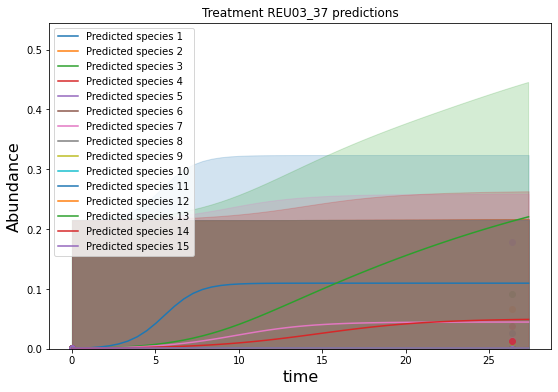

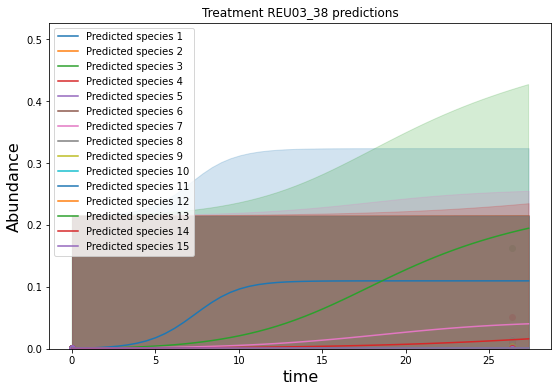

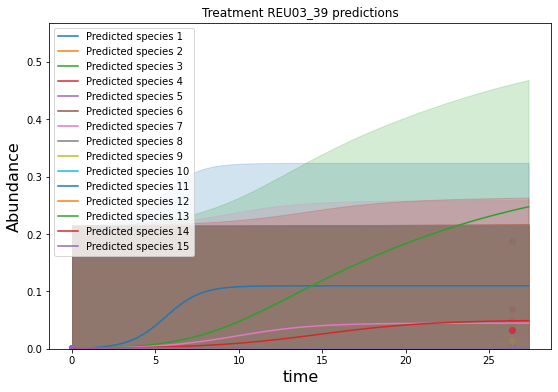

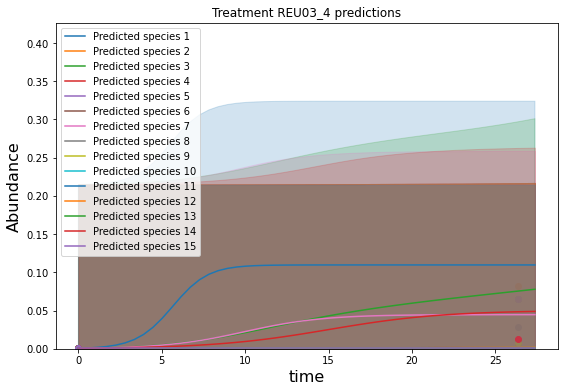

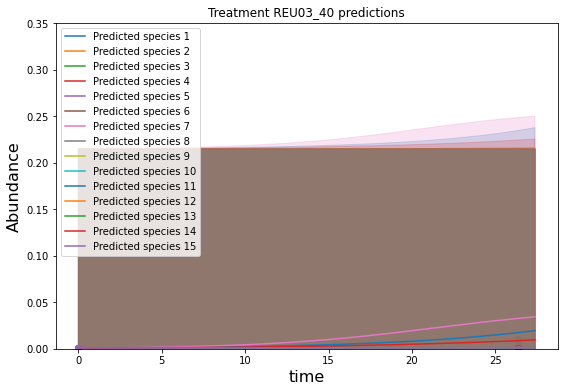

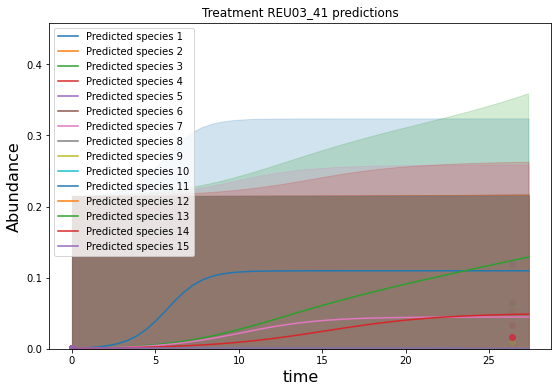

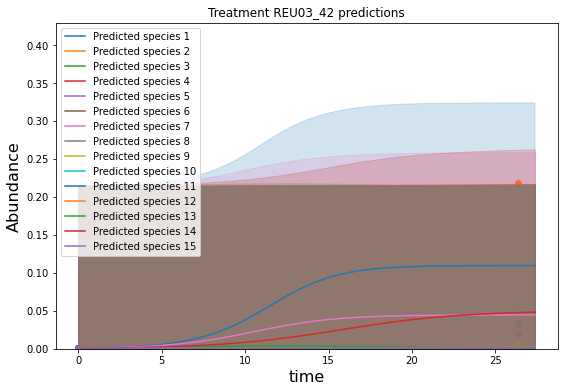

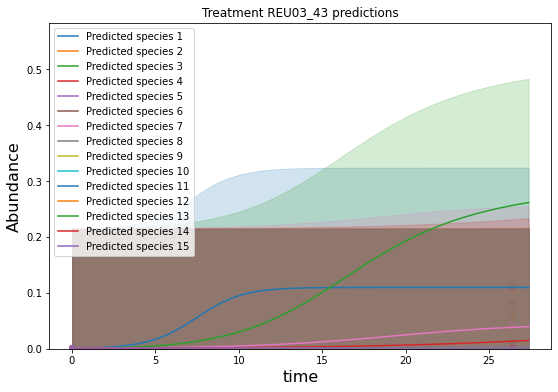

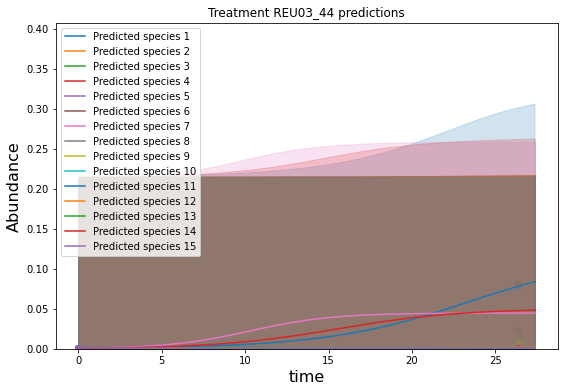

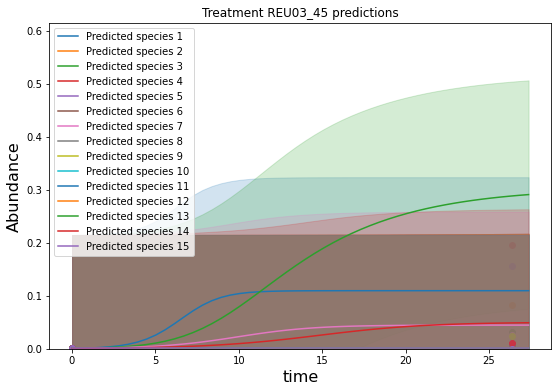

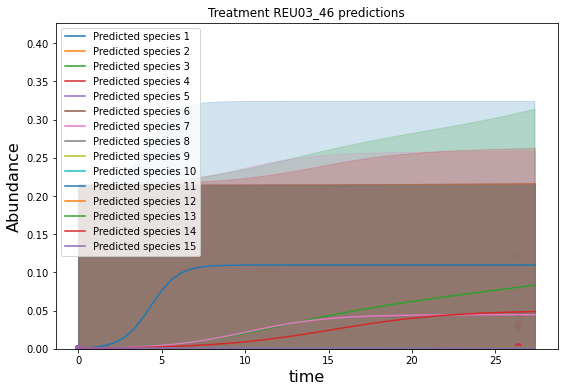

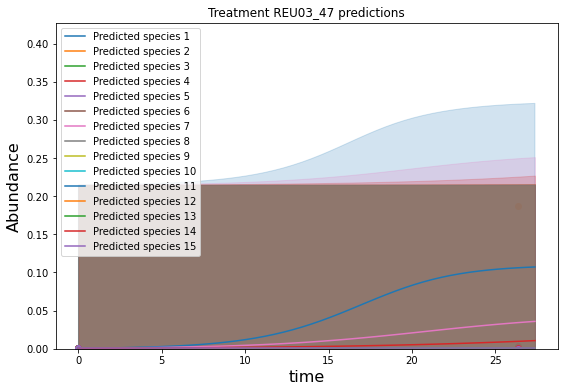

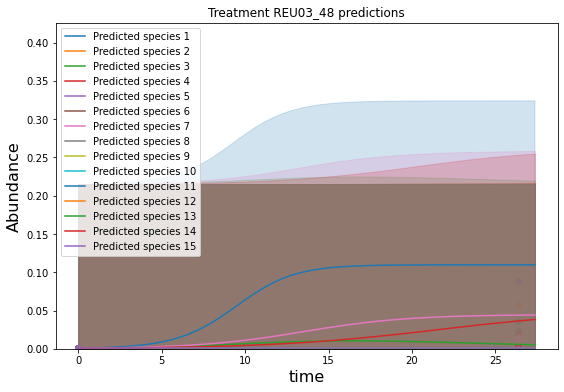

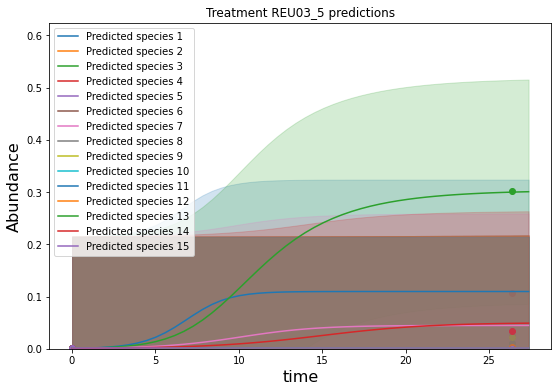

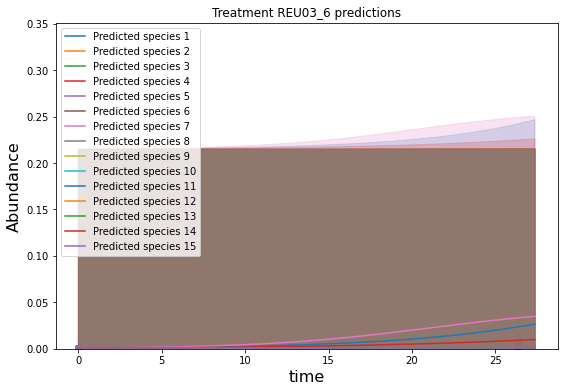

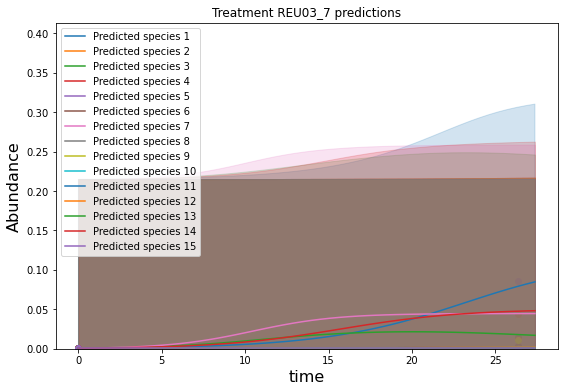

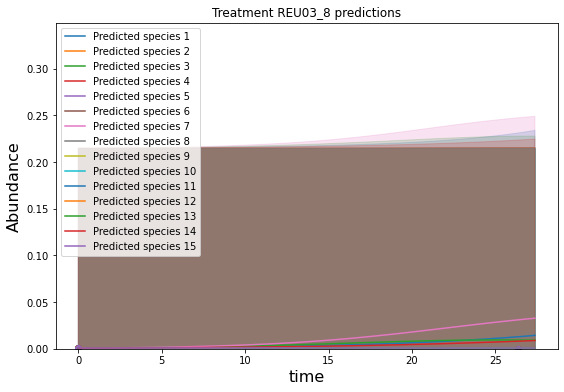

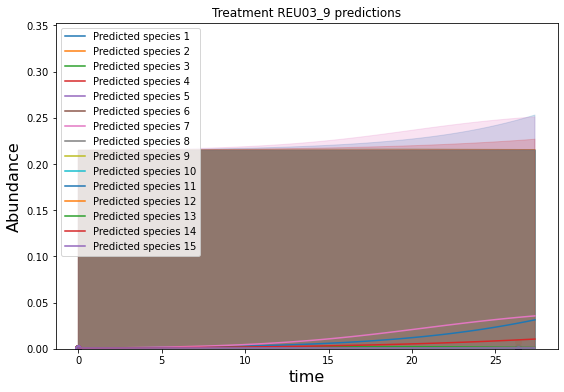

In [12]:
test_treatments, test_times, all_species_names, y_true, y_pred, y_std = test_model(model, avg_data, max_od, species, plot=True)

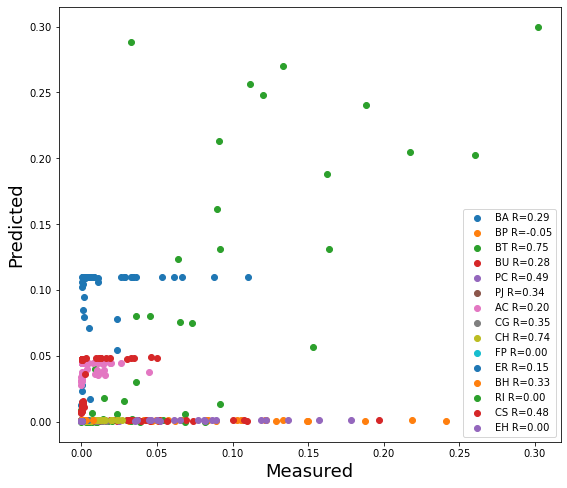

In [13]:
r_vals = []
plt.figure(figsize=(9,8))
for s in species:
    y_inds = np.in1d(all_species_names, s)
    y_s_true = np.array(y_true)[y_inds]
    y_s_pred = np.array(y_pred)[y_inds]
    
    r = linregress(y_s_true, y_s_pred).rvalue
    r_vals.append(r)
    plt.scatter(y_s_true, y_s_pred, label=s.replace("abs","")+" R={:.2f}".format(r))
plt.legend()
plt.xlabel("Measured", fontsize=18)
plt.ylabel("Predicted", fontsize=18)

plt.savefig("Results/node_fit_mf.pdf", dpi=200)
plt.show()

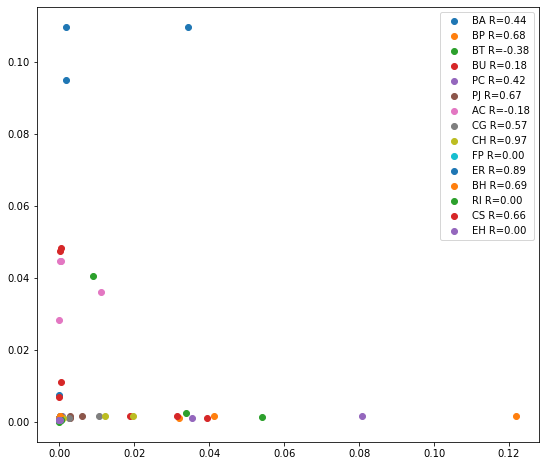

0.4419253006948517


In [14]:
plt.figure(figsize=(9,8))
r_vals = []
for s in species:
    y_inds = np.in1d(kfold_species_names, s)
    y_s_true = np.array(kfold_y_true)[y_inds]
    y_s_pred = np.array(kfold_y_pred)[y_inds]
    
    r = linregress(y_s_true, y_s_pred).rvalue
    r_vals.append(r)
    plt.scatter(y_s_true, y_s_pred, label=s.replace("abs","")+" R={:.2f}".format(r))
plt.legend()
#plt.ylim([0,.5])
plt.show()
print(np.median(r_vals))